# Research with Professor Margutti

## Understanding the Photometry of the Kilonova from GW170817

In [796]:
import sys
sys.path.append('/Users/kristophermortensen/NUREU17/LSST/TargetOfOpportunityStrategy')
from Kilonova_Class import kilonova
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import numpy as np
import astropy as astro
import random
import pandas
import sncosmo
import pyqt_fit
import os
import scipy
import matplotlib.colors as colors
import matplotlib.cm as cmx
import astropy.units as u
import matplotlib.gridspec as gridspec
import pyqt_fit.nonparam_regression as smooth
import statsmodels.api as sm
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value
from matplotlib import rc
from astropy.table import Table, Column, vstack
from astropy.io import ascii
from astropy.time import Time
from scipy.constants import h,k,c,Stefan_Boltzmann
from scipy.interpolate import interp1d, RegularGridInterpolator, UnivariateSpline
from scipy.integrate import quad
from scipy.optimize import curve_fit, minimize, fsolve
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, MaxNLocator, AutoLocator
from operator import itemgetter, attrgetter
from pyqt_fit import npr_methods
import warnings
warnings.filterwarnings('ignore')
matplotlib.style.use('classic')
plt.rcParams["figure.figsize"] = (3,4)
%matplotlib inline

In [797]:
# GW Sources
Villar = ascii.read("Villar Data.csv")

#Constants

# - plotting
tickfontsize = 20
axeslabelsize = 25
titlesize = 38
titley = 1.02
marker=1.2
legend = 17
points = 1
scale = 0.85
majorticklength = 7
minorticklength = 4
majortickwidth = 1
minortickwidth = 1

# - trigger
trigger = Time('2017-08-17 12:41:04')
trigger = trigger.mjd

In [798]:
#
# Bandpasses
#
        

# Filter
    
def bandpasses(folder):
    bandpasses = list_bandpass(folder)
    bandpasses1 = map_angstrom(bandpasses)
    bandpasses2 = map_transmission(bandpasses1)
    bandpasses3 = map_order(bandpasses2)
    bandpasses_new = clean_bandpasses(bandpasses3)
    return bandpasses_new

def list_bandpass(folder):
    band_passes = {}
    
    if folder == 'LSST Filters':
        x = 0
    else:
        x = 1
    for file in os.listdir(folder)[x:]:
        key = str(file)
        value = ascii.read(folder+"/"+file)
        band_passes[key[:-4]] = value
    
    return band_passes


def map_angstrom(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        
        if table.colnames[0] == 'wavelength(A)':
            table['wavelength(A)'] = table['wavelength(A)']
            table.rename_column('wavelength(A)', 'wavelength')
            bandpasses_new[key] = table
            
        elif table.colnames[0] == 'wavelength(nm)':
            table['wavelength(nm)'] = 10*table['wavelength(nm)']
            table.rename_column('wavelength(nm)', 'wavelength')
            bandpasses_new[key] = table
            
        elif table.colnames[0] == 'wavelength(mu)':
            table['wavelength(mu)'] = 10000*table['wavelength(mu)']
            table.rename_column('wavelength(mu)', 'wavelength')
            bandpasses_new[key] = table
            
        else:
            table.rename_column(table.colnames[0], 'wavelength')
            bandpasses_new[key] = table
    
    return bandpasses_new


def map_transmission(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        
        if table.colnames[1] == 'transmission':
            bandpasses_new[key] = table
        
        elif table.colnames[1] == 'transmission(%)':
            table['transmission(%)'] = 0.01*table['transmission(%)']
            table.rename_column('transmission(%)', 'transmission')
            bandpasses_new[key] = table
    
    return bandpasses_new


def map_order(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        x = []
        y_wave = []
        y_trans = []
        for i in range(len(table)):
            x.append([table['wavelength'][i], table['transmission'][i]])
            
        y = sorted(x, key=itemgetter(0))
        
        for i in range(len(y)):
            y_wave.append(y[i][0])
            y_trans.append(y[i][1])
            
        table_new = Table((y_wave,y_trans), names=('wavelength', 'transmission'))
        bandpasses_new[key] = table_new
    return bandpasses_new

def clean_bandpasses(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        bandpasses_new[key] = clean_up(table)
    return bandpasses_new
        

def clean_up(table):
    df = table.to_pandas()
    df = df.groupby('wavelength', as_index=False)['transmission'].mean()
    new_table = Table.from_pandas(df)
    return new_table

            
# Plot        

def plot_bandpasses(bandpasses):
    interps = interp_bandpasses(bandpasses)
    print('This bandpass dictionary has the following bandpasses:')
    filter_list = list(bandpasses.keys())
    print()
    print(filter_list)
    print()
    plot_bandchoices(bandpasses, filter_list, interps)
    return

def plot_bandchoices(bandpasses, filter_list, interps):
    print('Choose bandpasses to plot (e.g. DECam g, SIRIUS Ks, UVOT M2) or plot all:')
    bandpass_choices = input()
    bandpass_choices = bandpass_choices.split(', ')
    if bandpass_choices[0] == 'all':
        for bandpass in filter_list:
            plot_bandpass(bandpasses, bandpass) 
    
    if all([bandpass in filter_list for bandpass in bandpass_choices]):
        for bandpass in bandpass_choices:
            plot_bandpass(bandpasses, bandpass)
            #plot_interpolations(bandpasses, bandpass, interps)
            
    else:
        print('Bandpasses not found. Please try again.')
        plot_bandchoices(bandpasses, filter_list, interps)
    return


def plot_bandpass(bandpasses, bandpass):
    majorLocatorx = MultipleLocator(500)
    majorFormatter = FormatStrFormatter('%d')
    minorLocatorx = MultipleLocator(100)
    majorLocatory = MultipleLocator(0.2)
    minorLocatory = MultipleLocator(0.04)
    table = bandpasses[bandpass]
    fig = plt.figure(figsize=(14,11))
    ax1 = plt.subplot(111)

    #data
    plt.plot(table['wavelength'], table['transmission'])

    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Wavelength (Angstroms)', fontsize=axeslabelsize)
    plt.ylabel('Transmission', fontsize=axeslabelsize)
    plt.ylim(0.0, 1.0)
    xticks, xticklabels = plt.xticks()
    # shift half a step to the left
    # x0 - (x1 - x0) / 2 = (3 * x0 - x1) / 2
    xmin = (3*xticks[0] - xticks[1])/2
    # shaft half a step to the right
    xmax = (3*xticks[-1] - xticks[-2])/2.
    plt.xlim(xmin, xmax)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_locator(majorLocatory)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_minor_locator(minorLocatory)

    #plt.title(bandpass, fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    return




#
# Interpolations
#


def interp_bandpasses(bandpasses):
    approx = 'cubic'
    interpolations = {}
    
    for key,table in bandpasses.items():
        interp = interp1d(table['wavelength'], table['transmission'], bounds_error=False, fill_value=0)
        interpolations[key] = interp
    return interpolations


def plot_interpolations(bandpasses, bandpass, interps):
    majorLocatorx = MultipleLocator(500)
    majorFormatter = FormatStrFormatter('%d')
    minorLocatorx = MultipleLocator(100)
    majorLocatory = MultipleLocator(0.2)
    minorLocatory = MultipleLocator(0.04)
    table = bandpasses[bandpass]
    fig = plt.figure(figsize=(11,8))
    ax1 = plt.subplot(111)
    new_wavelengths = wavelength_new(table)

    #data
    plt.plot(new_wavelengths, interps[bandpass](new_wavelengths))

    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('Wavelength (Angstroms)', fontsize=axeslabelsize)
    plt.ylabel('Transmission', fontsize=axeslabelsize)
    plt.ylim(0.0, 1.0)
    xticks, xticklabels = plt.xticks()
    # shift half a step to the left
    # x0 - (x1 - x0) / 2 = (3 * x0 - x1) / 2
    xmin = (3*xticks[0] - xticks[1])/2
    # shaft half a step to the right
    xmax = (3*xticks[-1] - xticks[-2])/2.
    plt.xlim(xmin, xmax)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_locator(majorLocatory)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.yaxis.set_minor_locator(minorLocatory)

    plt.title(bandpass+' Interpolation', fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    return
    

def wavelength_new(table):
    set_length=10000
    day_new = np.linspace(min(table['wavelength']),
                          max(table['wavelength']),set_length)
    return day_new

In [799]:
band_passes = bandpasses("Telescope Filters")

In [800]:
#plot_bandpasses(band_passes)

In [801]:
#
# Lambda Effective (Average)
#

def lambda_effectives(bandpasses):
    interps = interp_bandpasses(bandpasses)
    bandpasses_new = {}
    for key, table in bandpasses.items():
        global interp
        interp = interps[key]
        bandpasses_new[key] = calc_lambda(table, interp)
    if 'MASTER R' and 'MASTER B' in list(bandpasses_new.keys()):
        bandpasses_new['MASTER W'] = 0.8*bandpasses_new['MASTER R']+0.2*bandpasses_new['MASTER B'] 
    return bandpasses_new


def calc_lambda(table, interp):
    lambda_eff = np.divide(quad(f, min(wavelength_new(table)), max(wavelength_new(table)))[0],
                           quad(interp, min(wavelength_new(table)), max(wavelength_new(table)))[0])
    return lambda_eff

def f(x):
    return x*interp(x)


# REFERENCE
def lambda_ref(bandpasses):
    bandpasses_new = {}
    for key, table in bandpasses.items():
        bandpasses_new[key] = calc_ref(table)
    return bandpasses_new

def calc_ref(table):
    wavelength = table['wavelength']
    transmission = table['transmission']
    bandpass = sncosmo.Bandpass(wavelength, transmission)
    return bandpass.wave_eff


# COMPARISON

def compare_lambdas(bandpasses):
    dictionary = {}
    observed = lambda_effectives(bandpasses)
    expected = lambda_ref(bandpasses)
    for key, value in observed.items():
        for key1, value1 in expected.items():
            if key == key1:
                dictionary[key] = [value1, value, value1-value]        
    return Table([list(dictionary.keys()), list(np.array(list(dictionary.values()))[:, 0].flatten()),
                  list(np.array(list(dictionary.values()))[:, 1].flatten()), list(np.array(list(dictionary.values()))[:, 2].flatten())],
                 names=('Filter', 'Expected Wavelength', 'Observed Wavelength', 'Difference'))


def wavelength_new(table):
    set_length=10000
    day_new = np.linspace(min(table['wavelength']),
                          max(table['wavelength']),set_length)
    return day_new

In [802]:
lambda_eff = lambda_effectives(band_passes)

In [803]:
#
# Extinction Coefficient
#


f_lambda = ascii.read('f_lambda.txt')
R = 3.1
E_BV = 0.1053
E_err = 0.0012
A_V = R*E_BV
A_B = E_BV+A_V


def f_interp(data = f_lambda):
    approx = 'cubic'
    interp = interp1d(data['1/lambda'], data['f(lambda)'], kind=approx)
    return interp


#
# Plotting
#


def f_plot(data = f_lambda):
    majorLocatorx = MultipleLocator(2)
    majorFormatter = FormatStrFormatter('%d')
    minorLocatorx = MultipleLocator(0.5)
    majorLocatory = MultipleLocator(2)
    minorLocatory = MultipleLocator(0.4)
    fig = plt.figure(figsize=(11,8))
    ax1 = plt.subplot(111)
    lambda_inv = f_new(data)
    interp = f_interp(data)
    f_lambdas = np.divide(interp(lambda_inv)+R, 1+R)

    #data
    plt.plot(10000*lambda_inv, f_lambdas)

    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.xlabel('1/$\\lambda$ Reciprocal Wavelength ($\\mu$m$^{-1}$)', fontsize=axeslabelsize)
    plt.ylabel('A$_\\lambda$/A$_B$', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    plt.ylim(0,np.ceil(max(f_lambdas)))
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_locator(majorLocatory)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax1.yaxis.set_minor_locator(minorLocatory)

    plt.title('Extinction Coefficients', fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    return

def f_new(data = f_lambda):
    set_length=10000
    day_new = np.linspace(min(data['1/lambda']),
                          max(data['1/lambda']),set_length)
    return day_new




#
# Extinction Magnitudes
#


def ext_mags(lambdas = lambda_eff, ext_co = f_lambda):
    mags = {}
    interp = f_interp(ext_co)
    for key, wavelength in lambdas.items():
        wave_inv = 1/wavelength
        A_lambda = np.divide(interp(wave_inv)+R, 1+R)*A_B
        mags[key] = A_lambda
    return mags
    

In [804]:
#f_plot()

In [805]:
extinctions = ext_mags()

In [806]:
#
# Flux Conversions
#

def convert_to_flux(gwsource=Villar):
    gwsource_cor = corrected_mags(gwsource)
    f_lambdas = calc_f_lambdas(gwsource_cor, 'magnitudes')
    f_sigmas = calc_f_lambdas(gwsource_cor, 'sigmas')
    
    col1 = Column(f_lambdas, name='flux')
    col2 = Column(f_sigmas, name='e_flux')
            
    titles = gwsource.colnames
    titles.remove('magnitude')
    titles.remove('e_magnitude')
    
    table = Table([gwsource[title] for title in titles], names=(title for title in titles))
    table.add_column(col2, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    table.add_column(col1, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    
    return table


#Note: this functions is for comparison

def convert_to_flux_noncorrected(gwsource=Villar):
    gwsource_cor = gwsource
    f_lambdas = calc_f_lambdas(gwsource_cor, 'magnitudes')
    f_sigmas = calc_f_lambdas(gwsource_cor, 'sigmas')
    
    col1 = Column(f_lambdas, name='flux')
    col2 = Column(f_sigmas, name='e_flux')
            
    titles = gwsource.colnames
    titles.remove('magnitude')
    titles.remove('e_magnitude')
    
    table = Table([gwsource[title] for title in titles], names=(title for title in titles))
    table.add_column(col2, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    table.add_column(col1, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    
    return table


def calc_f_lambdas(gwsource, choice):
    converted_data = []
    lambdas = lambda_eff
    c = astro.constants.c.to('Angstrom/s').value
    
    instruments = gwsource['instrument']
    bands = gwsource['band']
    
    if choice == 'magnitudes':
        data = calc_f_nus(gwsource)
    
    if choice == 'sigmas':
        data = calc_f_nus_sigmas(gwsource)
    
    
    for i in range(len(gwsource)):
        if instruments[i]+' '+bands[i] in list(lambdas.keys()):
            lam_eff = lambdas[instruments[i]+' '+bands[i]]
            flux = (c/(lam_eff**2))*data[i]
            converted_data.append(flux)
        
        elif instruments[i]+'_'+bands[i] in list(lambdas.keys()):
            lam_eff = lambdas[instruments[i]+'_'+bands[i]]
            flux = (c/(lam_eff**2))*data[i]
            converted_data.append(flux)
    return converted_data

def calc_f_nus(gwsource):
    Jy = 3631
    to_ergs = 10**(-23)
    fluxes = []
    mags = gwsource['magnitude']
    
    for mag in mags:
        flux = 10**(-0.4*(mag+48.6))
        fluxes.append(flux)
    return fluxes


def calc_f_nus_sigmas(gwsource):
    Jy = 3631
    to_ergs = 10**(-23)
    sig_fluxes = []
    sigmas = gwsource['e_magnitude']
    mags = gwsource['magnitude']
    
    for i in range(len(sigmas)):
            sig_flux = 0.4*(10**(-0.4*(mags[i]+48.6)))*np.log(10)*sigmas[i]
            sig_fluxes.append(sig_flux)
            
    return sig_fluxes



def lambda_dict(gwsource, lambdas):
    lambda_dictionary = {}
    filter_list = sort_filters(gwsource, 'band')
    for band in filter_list:
        band_list = []
        for key, value in lambdas.items():
            if key.endswith(band):
                band_list.append(value)
        common_band = np.mean(band_list)
        lambda_dictionary[band] = common_band
    return lambda_dictionary


#
# Exctinction Corrected Magnitudes
#

def corrected_mags(gwsource=Villar, exts=extinctions):
    mags_new = []
    e_mags_new = []
    instruments = gwsource['instrument']
    bands = gwsource['band']
    mags = gwsource['magnitude']
    e_mags = gwsource['e_magnitude']
    
    for i in range(len(gwsource)):
        if instruments[i]+' '+bands[i] in list(exts.keys()):
            correction = exts[instruments[i]+' '+bands[i]]
            mags_new.append(mags[i]-correction)
            e_mags_new.append(e_mags[i])
        
        elif instruments[i]+'_'+bands[i] in list(exts.keys()):
            correction = exts[instruments[i]+'_'+bands[i]]
            mags_new.append(mags[i]-correction)
            e_mags_new.append(e_mags[i])
            
    col1 = Column(mags_new, name='magnitude')
    col2 = Column(e_mags, name='e_magnitude')
            
    titles = gwsource.colnames
    titles.remove('magnitude')
    titles.remove('e_magnitude')
    
    table = Table([gwsource[title] for title in titles], names=(title for title in titles))
    table.add_column(col2, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    table.add_column(col1, index = np.where([titles[i]=='del_mag' for i in range(len(titles))])[0][0])
    return table
    

In [822]:
#
# LIGHT CURVES
#



def sort_filters(gwsource, column):
    column_data = gwsource[column]
    data_list = []
    for i in range(len(column_data)):   
        if column_data[i] not in data_list:
            data_list.append(column_data[i])
        else:
            data_list = data_list
    return data_list

def plot_light_curve(gwsource):
    print('The GW source has the following filters:')
    filter_list = sort_filters(gwsource, 'band')
    
    print()
    print(filter_list)
    print()
    
    print('Do you wish to plot in magnitude or flux?')
    choice = input()
    
    plot_mag_or_flux(gwsource, filter_list, choice)
    return


def plot_mag_or_flux(gwsource, filter_list, choice):
    
    
    if choice == 'magnitude':
        gwsource_cor = gwsource#corrected_mags(gwsource)
        plot_bands(gwsource_cor, filter_list, choice)
    
    elif choice == 'flux':
        print('Converting...')
        gwsource_flux = convert_to_flux(gwsource)
        plot_bands(gwsource_flux, filter_list, choice)
        
    else:
        print('Error: Choose magnitude or flux.')
        choice_new = input()
        plot_mag_or_flux(gwsource, filter_list, choice_new)

def plot_bands(gwsource, filter_list, choice):
    print('Choose filters to plot (e.g. u,g,r,i,z):')
    bands = input()
    bands = bands.split(',')
    
    if bands[0] == 'all':
        for band in filter_list:
            plot_mag(gwsource, band, filter_list, choice)
    
    elif all([band in filter_list for band in bands]):
        for band in bands:
            plot_mag(gwsource, band, filter_list, choice)
    
    else:
        print('Filters not found. Please try again.')
        plot_bands(gwsource, filter_list, choice)
    return

def plot_mag(gwsource, band, filter_list, choice):
    majorFormatter = FormatStrFormatter('%d')
    majorLocatorx = MultipleLocator(5)
    minorLocatorx = MultipleLocator(1)
    
    source_band = gwsource[np.where(gwsource['band'] == band)]
    upperlimits = upperlimit(source_band, choice)
    band_sigmas = sigmas(source_band, 'e_'+choice)
    
    fig = plt.figure(figsize=(9,7))
    ax1 = plt.subplot(111)

    #data
    plt.errorbar(reset_days(upperlimits['reg days'], trigger),
                 upperlimits['reg '+choice],yerr=band_sigmas['reg sig'],
                 fmt='o', color='white', ecolor='k', markeredgecolor='k', markeredgewidth = 1, label='Villar')

    #upper limits
    plt.errorbar(reset_days(upperlimits['lim days'], trigger),
                 upperlimits['lim '+choice], fmt='v', color='white',
                 markeredgecolor='k', markeredgewidth = 1, label=None)
    
    #LSST
    if band in ['u','g','r','i','z','y']:
        plt.errorbar(LSST['day'], LSST[band], fmt='o', color='orange',
                     markeredgecolor='k', markeredgewidth = 1, label='LSST')
        
        plt.plot(LSST_blue['day'], LSST_blue[band], '--', color='blue', label='LSST Blue')
        plt.plot(LSST_purple['day'], LSST_purple[band], '--', color='purple', label='LSST Purple')
        plt.plot(LSST_red['day'], LSST_red[band], '--', color='red', label='LSST Red')
        plt.plot(LSST_black['day'], LSST_black[band], '-', linewidth=2, color='black', label='LSST 3-Comp')
        
        plt.legend(loc='best', bbox_to_anchor=(1,1),
                   numpoints=1, fontsize=legend-2, frameon=False)
       
    
    else:
        None

    plt.xlabel('Time Since Trigger (Days)', fontsize=axeslabelsize)
    plt.xlim(0, round_up(max_column(gwsource, filter_list, 'time'),1)-trigger)
    xticks, xticklabels = plt.xticks()
    xmin = (3*xticks[0] - xticks[1])/12.
    plt.xlim(xmin, round_up(max_column(gwsource, filter_list, 'time'),1)-trigger)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_major_locator(majorLocatorx)
    ax1.xaxis.set_major_formatter(majorFormatter)
    ax1.xaxis.set_minor_locator(minorLocatorx)
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.yaxis.set_major_formatter(majorFormatter)
    
    
    if choice == 'magnitude':
        #interps = plot_data_interp(source_band, choice)
        #if interps is not None:
        #    plt.plot(interps[0], interps[1], color='r')
        majorFormatter1 = FormatStrFormatter('%d')
        majorLocatory = MultipleLocator(2)
        minorLocatory = MultipleLocator(0.4)
        plt.ylabel('Apparent Magnitude', fontsize=axeslabelsize)
        if band in ['u','g','r','i','z','y']:
            plt.ylim(round_up(max(np.max(source_band['magnitude']), np.max(LSST[band][np.isfinite(LSST[band])])),1),
                     round_down(min(np.min(source_band['magnitude']), np.min(LSST[band][np.isfinite(LSST[band])])),2))
        else:
            plt.ylim(round_up(np.max(source_band['magnitude']),1), round_down(np.min(source_band['magnitude']),2))
        ax1.yaxis.set_major_locator(majorLocatory)
        ax1.yaxis.set_major_formatter(majorFormatter1)
        ax1.yaxis.set_minor_locator(minorLocatory)
        
    elif choice == 'flux':
        interps = plot_data_interp(source_band, choice)
        if interps is not None:
            plt.plot(interps[0], interps[1], color='r')
        plt.ylabel('f$_\\lambda$', fontsize=axeslabelsize)
        minimum = np.min(gwsource['flux'])
        maximum = np.max(gwsource['flux'])
        ax1.set_yscale("log", nonposy='clip')
        plt.ylim(minimum-2*10**flux_order(minimum), maximum+2*10**flux_order(maximum))

    plt.title('Filter: '+band, fontsize = titlesize, y=titley)
    fig.tight_layout()
    fig.subplots_adjust(top=scale)
    plt.show()
    return



#
# Data Interpolations
#




def plot_data_interp(gwsource, choice):
    length = 10000
    
    if len(gwsource[choice]) < 3:
        if len(gwsource[choice]) == 2:
            data = gwsource[choice]
            sigma = gwsource['e_'+choice]
            time = reset_days(gwsource['time'], trigger)
            

            approx = 'linear'
            f = interp1d(time, data, kind=approx, bounds_error=False, fill_value='extrapolate')
            f_sig = interp1d(time, sigma, kind=approx, bounds_error=False, fill_value='extrapolate')
            
            

            time_new = np.linspace(min(time), max(time), length)
            data = np.array([time_new, f(time_new), f_sig(time_new)])
            return data
        else:
            return
    else:
        upperlimits = upperlimit(gwsource, choice)
        band_sigmas = sigmas(gwsource, 'e_'+choice)
        if len(upperlimits['reg '+choice]) < 3:
            if len(upperlimits['reg '+choice]) < 2:
                return
            elif len(upperlimits['reg '+choice]) == 2:
                data = upperlimits['reg '+choice]
                sigma = band_sigmas['reg sig']
                time = reset_days(upperlimits['reg days'], trigger)
            

                approx = 'linear'
                f = interp1d(time, data, kind=approx, bounds_error=False, fill_value='extrapolate')
                f_sig = interp1d(time, sigma, kind=approx, bounds_error=False, fill_value='extrapolate')



                time_new = np.linspace(min(time), max(time), length)
                data = np.array([time_new, f(time_new), f_sig(time_new)])
                return data
            else:
                selected_data = remove_outliers(gwsource['time'],
                                                gwsource[choice],
                                                gwsource['e_'+choice], 5)
                if len(selected_data[0]) < 3:
                    return
                else:
                    data = selected_data[1]
                    sigma = selected_data[2]
                    time = reset_days(selected_data[0], trigger)
                    fraction = 0.4
                    delta = 0.0
                    integer = 3
                    
                    lowess = sm.nonparametric.lowess(data, time, frac=fraction, delta=delta, it=integer)
                    lowess_sig = sm.nonparametric.lowess(sigma, time, frac=fraction, delta=delta, it=integer)
                    
                    lowess_table = Table([lowess[:,0], lowess[:,1]], names=('time', 'flux'))
                    lowess_sig_table = Table([lowess_sig[:,0], lowess_sig[:,1]], names=('time', 'sigma'))
                    
                    interp_data = clean_up_flux(lowess_table)
                    interp_sig = clean_up_flux(lowess_sig_table)
                    
                    approx = 'linear'
                    f = interp1d(interp_data['time'], interp_data['flux'], kind=approx, bounds_error=False,
                                 fill_value='extrapolate')
                    f_sig = interp1d(interp_sig['time'], interp_sig['sigma'], kind=approx, bounds_error=False,
                                     fill_value='extrapolate')

                    time_new = np.linspace(min(time), max(time), length)
                    
                    data_new = np.array([time_new, f(time_new), f_sig(time_new)])

                    return data_new
        else:
            selected_data = remove_outliers(upperlimits['reg days'], 
                                            upperlimits['reg '+choice], 
                                            band_sigmas['reg sig'], 5)
            if len(selected_data[0]) < 4:
                data = selected_data[1]
                sigma = selected_data[2]
                time = reset_days(selected_data[0], trigger)
                
                
                approx='linear'
                f = interp1d(time, data, kind=approx, bounds_error=False, fill_value='extrapolate')
                f_sig = interp1d(time, sigma, kind=approx, bounds_error=False, fill_value='extrapolate')
                
                time_new = np.linspace(min(time), max(time), length)
                data = np.array([time_new, f(time_new), f_sig(time_new)])
                return data
            else:
                
                selected_data = remove_outliers(upperlimits['reg days'], 
                                            upperlimits['reg '+choice], 
                                            band_sigmas['reg sig'], 4)
                
                data = selected_data[1]
                sigma = selected_data[2]
                time = reset_days(selected_data[0], trigger)
                
                if len(data) < 10:
                    interp_data = smooth.NonParamRegression(time, data, 
                                                            method=npr_methods.LocalPolynomialKernel(q=1))
                    interp_data.fit()

                    interp_sigma = smooth.NonParamRegression(time, sigma, 
                                                            method=npr_methods.LocalPolynomialKernel(q=1))
                    interp_sigma.fit()
                    
                    time_new = np.linspace(min(time), max(time), length)
                    
                    approx = 'linear'
                    f  = interp1d(time_new, interp_data(time_new), kind=approx, bounds_error=False,
                                  fill_value='extrapolate')
                    
                    f_sig  = interp1d(time_new, interp_sigma(time_new), kind=approx, bounds_error=False,
                                  fill_value='extrapolate')

                    data_new = np.array([time_new, f(time_new), f_sig(time_new)])
                    return data_new
                    
                else:
                    if len(data) < 11:
                        fraction = 0.8
                        delta = 0.7
                    elif len(data) < 15:
                        fraction = 0.4
                        delta = 0.7
                    elif len(data) < 18:
                        fraction = 0.4
                        delta = 0.3
                    elif len(data) < 21:
                        fraction = 0.3
                        delta = 0.7
                    elif len(data) < 31:
                        fraction = 0.23
                        delta = 0.7
                    elif len(data) < 37:
                        fraction = 0.25
                        delta = 0.3
                    elif len(data) < 47:
                        fraction = 0.25
                        delta = 0.7
                    elif len(data) < 61:
                        fraction = 0.2
                        delta = 0.7
                    elif len(data) < 75:
                        fraction = 0.16
                        delta = 0.7
                    elif len(data) < 86:
                        fraction = 0.15
                        delta = 1.5
                    else:
                        fraction = 0.1
                        delta = 0.9
                    
                    integer = 2


                    lowess = sm.nonparametric.lowess(data, time, frac=fraction, delta=delta, it=integer)
                    lowess_sig = sm.nonparametric.lowess(sigma, time, frac=fraction, delta=delta, it=integer)

                    lowess_table = Table([lowess[:,0], lowess[:,1]], names=('time', 'flux'))
                    lowess_sig_table = Table([lowess_sig[:,0], lowess_sig[:,1]], names=('time', 'sigma'))

                    interp_data = clean_up_flux(lowess_table)
                    interp_sig = clean_up_flux(lowess_sig_table)
                    
                    approx = 'linear'
                    f = interp1d(interp_data['time'], interp_data['flux'], kind=approx)
                    f_sig = interp1d(interp_sig['time'], interp_sig['sigma'], kind=approx)

                    time_new = np.linspace(min(time), max(time), length)

                    data_new = np.array([time_new, f(time_new), f_sig(time_new)])
                    

                    return data_new
    return



def clean_up_flux(table):
    df = table.to_pandas()
    if table.colnames[1] == 'flux':
        df_new = df.groupby('time', as_index=False)['flux'].mean()
    elif table.colnames[1] == 'sigma':
        df_new = df.groupby('time', as_index=False)['sigma'].mean()
    new_table = Table.from_pandas(df_new)
    return new_table



#
# Sigmas & Upperlimits
#

def upperlimit(source, choice):
    upperlimits = source['upperlimit']
    reg_list_choice = []
    up_list_choice = []
    reg_list_time = []
    up_list_time = []
    for i in range(len(upperlimits)):
        if upperlimits[i] == 'T':
            up_list_choice.append(source[choice][i])
            up_list_time.append(source['time'][i])
        else:
            reg_list_choice.append(source[choice][i])
            reg_list_time.append(source['time'][i])
    return {'reg '+choice: reg_list_choice, 'lim '+choice: up_list_choice,
            'reg days': reg_list_time, 'lim days': up_list_time}

def sigmas(source, choice):
    upperlimits = source['upperlimit']
    reg_list_sig = []
    up_list_sig = []
    for i in range(len(upperlimits)):
        if upperlimits[i] == 'T':
            up_list_sig.append(source[choice][i])
        else:
            reg_list_sig.append(source[choice][i])
    return {'reg sig': reg_list_sig, 'lim sig': up_list_sig}


def remove_outliers(times, data, sigmas, num):
    m = num
    average = np.mean(data)
    stdev = np.std(data)
    filtered_data = []
    filtered_sigmas= []
    filtered_times = []
    for measurement, error, time in zip(data, sigmas, times):
        if abs(measurement - average) < m * stdev:
            filtered_data.append(measurement)
            filtered_sigmas.append(error)
            filtered_times.append(time)
        else:
            filtered_data = filtered_data
            filtered_sigmas = filtered_sigmas
            filtered_times = filtered_times
    return np.array([filtered_times, filtered_data, filtered_sigmas])




#
# Plotting Parameters
#

#round_up: number base -> number
#Rounds the number up to the nearest multiple of the base number.
def round_up(x, base=5):
    return int(base * (np.ceil(float(x)/base)+1))

#round_down: number base -> number
#Rounds the number down to the nearest multiple of the base number.
def round_down(x, base=5):
    return int(base * (np.floor(float(x)/base)))


def reset_days(times, trigger):
    time_new = []
    for time in times:
        time_new.append(time-trigger)
    return time_new


def max_column(gwsource, filter_list, column):
    max_list = []
    for band in filter_list:
        max_list.append(np.max(gwsource[column][np.where(gwsource['band'] == band)]))
    return np.max(max_list)


def flux_order(x):
    return int(np.floor(np.log10(x)))



#
# Extra Functions
#

def plot_another(gwsource, filter_list):
    print('Plot more light curves? (y/n)')
    choice = input()
    if choice == 'y' or choice == 'yes':
        print('Choose filters to plot (e.g. u,g,r,i,z):')
        bands_new = input()
        bands_new = bands_new.split(',')
        for band_new in bands_new:
            plot_band(gwsource, band_new, filter_list)
        plot_another(gwsource, filter_list)
    elif choice == 'n' or choice == 'no':
        return
    else:
        plot_another(gwsource, filter_list)
    return

The GW source has the following filters:

['i', 'H', 'r', 'Ks', 'J', 'V', 'z', 'W', 'g', 'w', 'Y', 'M2', 'W1', 'U', 'W2', 'y', 'B', 'I', 'R', 'K', 'u', 'J1', 'F110W', 'F160W', 'F336W', 'J8.9', 'F606W', 'F475W', 'F625W', 'F775W', 'F850W', 'F814W', 'F225W', 'F275W']

Do you wish to plot in magnitude or flux?
Converting...
Choose filters to plot (e.g. u,g,r,i,z):


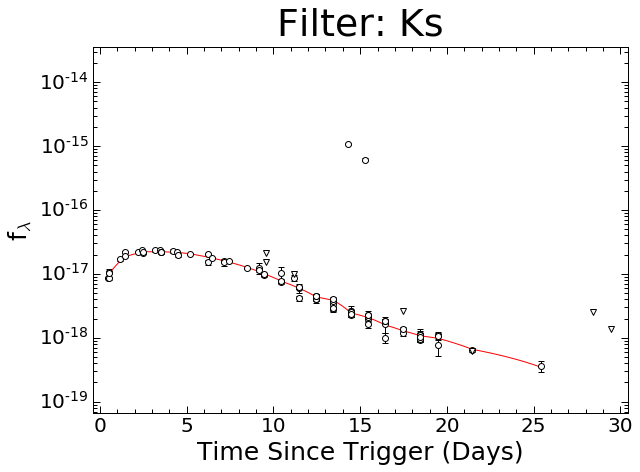

In [13]:
plot_light_curve(Villar)

In [808]:
#
# SEDs
#

def SED(simulated = False, gwsource = Villar):
    print('Pick days after merger to plot (e.g. 1,5.7,20.368).')
    timez = input()
    timez = timez.split(',')
    times = np.fromiter([time for time in timez], float)
    max_lambdas = []
    min_lambdas = []
    max_fluxes = []
    min_fluxes = []
    
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(111)
    
    values = range(len(times))
    jet = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    Blacks = Blues = mcol.LinearSegmentedColormap.from_list("MyCmapName",["black","white"])
    Blues = mcol.LinearSegmentedColormap.from_list("MyCmapName",["blue","white"])
    Purples = mcol.LinearSegmentedColormap.from_list("MyCmapName",["purple","white"])
    Reds = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red","white"])
    BlackMap = cmx.ScalarMappable(norm=cNorm, cmap=Blacks)
    BlueMap = cmx.ScalarMappable(norm=cNorm, cmap=Blues)
    PurpleMap = cmx.ScalarMappable(norm=cNorm, cmap=Purples)
    RedMap = cmx.ScalarMappable(norm=cNorm, cmap=Reds)
    
    rc('text', usetex=True)
    
    for time,i in zip(times, values):
        colorVal = scalarMap.to_rgba(values[i])
        BlackVal = BlackMap.to_rgba(values[i])
        BlueVal = BlueMap.to_rgba(values[i])
        PurpleVal = PurpleMap.to_rgba(values[i])
        RedVal = RedMap.to_rgba(values[i])
        
        if simulated == True:
            data_tot = BB_seds(times, ThreeComp)
            data_blue = BB_seds(times, Blue)
            data_purple = BB_seds(times, Purple)
            data_red = BB_seds(times, Red)
            
            plt.plot(data_tot[i]['lambda'], data_tot[i]['flux'], color=BlackVal,
                     label='\\textbf{t}$_\\mathbf{3-comp}$ \\textbf{= %.1f days}' % (time))
            plt.plot(data_blue[i]['lambda'], data_blue[i]['flux'], color=BlueVal,
                     label='\\textbf{t}$_\\mathbf{blue}$ \\textbf{= %.1f days}' % (time))
            plt.plot(data_purple[i]['lambda'], data_purple[i]['flux'], color=PurpleVal,
                     label='\\textbf{t}$_\\mathbf{purple}$ \\textbf{= %.1f days}' % (time))
            plt.plot(data_red[i]['lambda'], data_red[i]['flux'], color=RedVal,
                     label='\\textbf{t}$_\\mathbf{red}$ \\textbf{= %.1f days}' % (time))
            
            data = vstack([data_tot[i], data_blue[i], data_purple[i], data_red[i]])
            ax1.legend(loc=1, bbox_to_anchor=(1.27,1),
                       numpoints=1, fontsize=legend-1, frameon=False)
            
        else:
            data = sed_data(gwsource, time)
            
            interp = blackbody_curve(time, data)
            parameters, covariances = optimal_blackbody(time, data)
            sigma0, sigma1 = np.sqrt(np.diag(covariances))

            data_plot = plt.errorbar(data['lambda'], data['flux'] ,yerr=data['e_flux'],
                                     fmt='o', color = colorVal, markeredgecolor='k', markeredgewidth = 1,
                                     label='\\textbf{t = %.1f days}' % (time))
            
            interp_plot = plt.plot(interp[0], interp[1], color = colorVal,
                               label='T = %.2fK +/- %.2fK; \nR = %.2Ecm +/- %.2Ecm' % (parameters[0], sigma0, 
                                                                                       parameters[1], sigma1))
            
            handles_list = []
            labels_list = []
            handles, labels = ax1.get_legend_handles_labels()
            for i in range(int(len(handles)/2)):
                handles_list.append(handles[i+int(len(handles)/2)])
                handles_list.append(handles[i])
                labels_list.append(labels[i+int(len(labels)/2)])
                labels_list.append(labels[i])

            ax1.legend(handles_list, labels_list, loc=1, bbox_to_anchor=(1.37,1),
                       numpoints=1, fontsize=legend-1, frameon=False)
        
        
        max_lambdas.append(np.max(data['lambda']))
        min_lambdas.append(np.min(data['lambda']))
        max_fluxes.append(np.max(data['flux']))
        min_fluxes.append(np.min(data['flux']))
    
    majorLocator = AutoLocator()
    minorLocator = AutoMinorLocator()
    plt.xlabel('$\\lambda$ ($\\mathbf{\\AA}$)', fontsize=axeslabelsize)
    plt.ylabel('F$_\\lambda$ (J s$^{\\mathbf{-1}}$ m$^{\\mathbf{-1}}$ m$^{\\mathbf{-2}}$)',
               fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_major_locator(majorLocator)
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.set_yscale("log", nonposy='clip')
    min_lambda = np.min(min_lambdas)
    max_lambda = np.max(max_lambdas)
    min_flux = np.min(min_fluxes)
    max_flux = np.max(max_fluxes)
    plt.xlim(0, max_lambda+1000)
    plt.ylim(min_flux-1e-11, max_flux+5e-9)
    return


def sed_data(gwsource, time):
    lambdas = lambda_dict(gwsource, lambda_eff)
    filter_list = sort_filters(gwsource, 'band')
    
    flux_source = convert_to_flux(gwsource)
    #flux_source_noncor = convert_to_flux_noncorrected(gwsource)
    #mag_source = gwsource
    #mag_source_noncor = gwsource
    
    flux_interps = sed_interps(flux_source, 'flux', filter_list)
    #flux_interps_noncor = sed_interps(flux_source_noncor, 'flux', filter_list)
    #mag_interps = sed_interps(mag_source, 'magnitude', filter_list)
    #mag_interps_noncor = sed_interps(mag_source_noncor, 'magnitude', filter_list)
    
    sed_data_flux = evaluate_fluxes(time, flux_source, flux_interps, filter_list, lambdas, 'flux')
    #sed_data_flux_noncor = evaluate_fluxes(time, flux_source_noncor, flux_interps_noncor, filter_list, lambdas, 'flux')
    #sed_data_mag = evaluate_fluxes(time, mag_source, mag_interps, filter_list, lambdas, 'magnitude')
    #sed_data_mag_noncor = evaluate_fluxes(time, mag_source_noncor, mag_interps_noncor, filter_list, lambdas, 'magnitude')
    
    #sed_data = Table([sed_data_flux['lambda'],
     #                 sed_data_flux_noncor['flux'], sed_data_flux_noncor['e_flux'],
     #                 sed_data_flux['flux'], sed_data_flux['e_flux'],
     #                 sed_data_mag_noncor['magnitude'], sed_data_mag_noncor['e_magnitude'],
     #                 sed_data_mag['magnitude'], sed_data_mag['e_magnitude']],
     #                names=('lambda',
     #                       'flux', 'e_flux',
     #                       'cor. flux', 'cor. e_flux',
     #                       'mag', 'e_mag',
     #                       'cor. mag', 'cor. e_mag'))
    
    
    return sed_data_flux


def evaluate_fluxes(time, source, interps, bands, lambdas, choice):
    lambda_list = []
    flux_list = []
    error_list = []
    for band in bands:
        times = reset_days(source[np.where(source['band']==band)]['time'], trigger)
        min_time = np.min(times)
        max_time = np.max(times)
        if time > min_time and time < max_time and interps[band] is not None:
            if choice == 'flux':
                flux = interps[band][0](time)*10**7
                e_flux = interps[band][1](time)*10**7
                if flux < 0:
                    lambda_list = lambda_list
                    flux_list = flux_list
                    error_list = error_list
                else:
                    lambda_list.append(lambdas[band])
                    flux_list.append(flux)
                    error_list.append(abs(e_flux))
            elif choice == 'magnitude':
                flux_list.append(interps[band][0](time))
                error_list.append(interps[band][1](time))
        else:
            if band in ['U', 'M2', 'W1'] and time < min_time:
                if choice == 'flux':
                    flux = interps[band][0](time)*10**7
                    e_flux = interps[band][1](time)*10**7
                    if flux < 0:
                        lambda_list = lambda_list
                        flux_list = flux_list
                        error_list = error_list
                    else:
                        lambda_list.append(lambdas[band])
                        flux_list.append(flux)
                        error_list.append(abs(e_flux))
                elif choice == 'magnitude':
                    lambda_list.append(lambdas[band])
                    flux_list.append(interps[band][0](time))
                    error_list.append(interps[band][1](time))
            
            else:
                lambda_list = lambda_list
                flux_list = flux_list
                error_list = error_list
    
    lambda_list_new = []
    flux_list_new = []
    error_list_new = []
    for i in range(len(flux_list)):
        if flux_list[i]/np.mean(flux_list) < 3:
            lambda_list_new.append(lambda_list[i])
            flux_list_new.append(flux_list[i])
            error_list_new.append(error_list[i])
        else:
            lambda_list_new = lambda_list_new
            flux_list_new = flux_list_new
            error_list_new = error_list_new
    
    return Table([lambda_list_new, flux_list_new, error_list_new], names=('lambda', choice, 'e_'+choice))
        
    

def sed_interps(gwsource, choice, filter_list):
    interps = {}
    for band in filter_list:
        source_band = gwsource[np.where(gwsource['band'] == band)]
        interps[band] = data_interp(source_band, choice)
    return interps

def data_interp(gwsource, choice):
    approx = 'linear'
    interp_list = plot_data_interp(gwsource, choice)
    if interp_list is None:
        interp = None
    else:
        interp = [interp1d(interp_list[0], interp_list[1], kind=approx, fill_value='extrapolate'), 
                  interp1d(interp_list[0], interp_list[2], kind=approx, fill_value='extrapolate')]
        
    return interp


In [809]:
Example = ascii.read('0.6 Example.txt')

In [810]:
#
# Black-Body Fits
#

def blackbody_curve(time, sed_source):
    steps = 1000
    parameters, covariances = optimal_blackbody(time, sed_source)
    temp = parameters[0]
    radius = parameters[1]
    min_lambda = np.min(sed_source['lambda'])
    max_lambda = np.max(sed_source['lambda'])
    lambdas = np.linspace(min_lambda, max_lambda, steps)
    
    curve = np.array([lambdas, blackbody_function(lambdas, temp, radius)])
    return curve
    


def optimal_blackbody(time, sed_source = Villar):
    if sed_source is Villar:
        data = sed_data(sed_source, time)
    else:
        data = sed_source
    if data is Example:
        lambdas = data['lambda']
        fluxes = data['flux']
        parameters, covariances = curve_fit(blackbody_function,
                                            lambdas, fluxes, p0=[8e3, 4e14])
    else:
        table = map_lambda_order(data)
        #table_new = remove_outliers_flux(table['lambda'], table['flux'], table['e_flux'])
        lambdas = table['lambda']
        fluxes = table['flux']
        sigmas = table['e_flux']
        parameters, covariances = curve_fit(blackbody_function,
                                            lambdas, fluxes, p0=[8e3, 4e14],
                                           sigma=sigmas)
    return parameters, covariances


def blackbody_function(lam, T, R, dist = 40.7):
    """ Blackbody as a function of wavelength (angstrom) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    conversion = 3.085677581e+24 #Mpc to cm
    d = dist*conversion
    z = z_at_value(cosmo.luminosity_distance, dist*u.Mpc)
    
    lam = 1e-10*(lam*(1+z)) # angstroms to meters (adjusted redshift)
    flux = ((2*h*c**2) / (lam**5))*(1/(np.exp((h*c)/(lam*k*T)) - 1))*np.pi*(R/d)**2
    return flux

def map_lambda_order(table):
    x = []
    y_lam = []
    y_flux = []
    y_err = []
    for i in range(len(table)):
        x.append([table['lambda'][i], table['flux'][i], table['e_flux'][i]])

    y = sorted(x, key=itemgetter(0))

    for i in range(len(y)):
        y_lam.append(y[i][0])
        y_flux.append(y[i][1])
        y_err.append(y[i][2])

    table_new = Table((y_lam,y_flux, y_err), names=('lambda', 'flux', 'e_flux'))
    return table_new

def remove_outliers_flux(lambdas, fluxes, sigmas):
    m = 5
    average = np.mean(fluxes)
    stdev = np.std(fluxes)
    filtered_fluxes = []
    filtered_sigmas= []
    filtered_lambdas = []
    for flux, error, lam in zip(fluxes, sigmas, lambdas):
        if abs(flux - average) < m * stdev:
            filtered_fluxes.append(flux)
            filtered_sigmas.append(error)
            filtered_lambdas.append(lam)
        else:
            filtered_fluxes = filtered_fluxes
            filtered_sigmas = filtered_sigmas
            filtered_lambdas = filtered_lambdas
    return Table([filtered_lambdas, filtered_fluxes, filtered_sigmas],
                 names=('lambda', 'flux', 'e_flux'))

Pick days after merger to plot (e.g. 1,5.7,20.368).


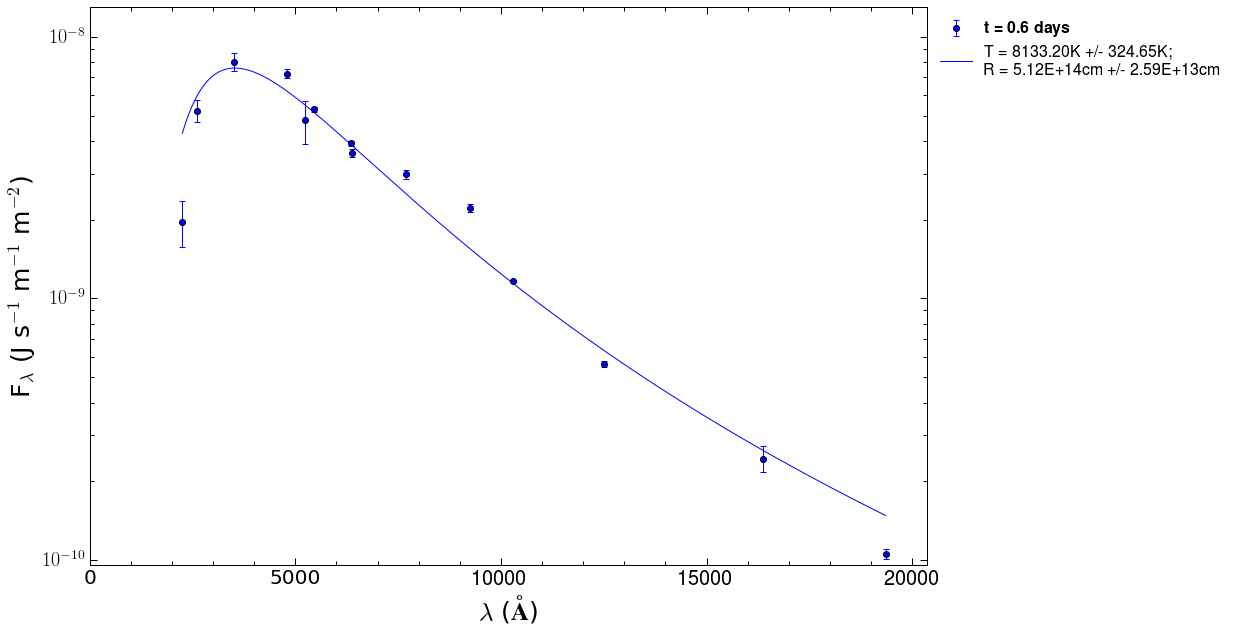

In [811]:
SED()

In [812]:
sig = Stefan_Boltzmann

def sed_table(gwsource = Villar):
    temp_list = []
    radius_list = []
    temp_sigma_list = []
    radius_sigma_list = []
    dof_list = []
    chi2_list = []
    L_bol_list = []
    L_bol_sig_list = []
    L_bol_list_BB = []
    L_bol_sig_list_BB = []
    
    
    print('Pick days after merger to plot (e.g. 1,5.7,20.368).')
    timez = input()
    timez = timez.split(',')
    times = []
    for time in timez:
        time_float = float(time)
        times.append(time_float)
        
    for time in times:
        data = sed_data(gwsource, time)
        
        #T and R with sigmas
        parameters, covariances = optimal_blackbody(time, data)
        temp_sig, radius_sig = np.sqrt(np.diag(covariances))
        temp = parameters[0]
        radius = parameters[1]
        temp_list.append(temp)
        radius_list.append(radius)
        temp_sigma_list.append(temp_sig)
        radius_sigma_list.append(radius_sig)
        
        
        #Chi^2 and degrees of freedom
        exp_data = blackbody_function(data['lambda'],parameters[0],parameters[1])
        dof = len(data)-len(parameters)
        dof_list.append(dof)
        chi2 = []
        for i in range(len(data)):
            chi = (data['flux'][i]-exp_data[i])**2/(data['e_flux'][i])**2
            if chi < 400:
                chi2.append(chi)
            else:
                chi2 = chi2
        chi2_tot = np.sum(chi2)
        chi2_list.append(chi2_tot)
        
        #Bolometric Luminosity
        conversion = 3.085677581e+24 #Mpc to cm
        d = 40.7*conversion
        to_erg = 1e7
        min_lambda = np.min(data['lambda'])
        max_lambda = np.max(data['lambda'])
        #lambdas = np.linspace(min_lambda, max_lambda, 1000)
        interp = Fbol_interp(data)
        Fbol = quad(interp, min_lambda, max_lambda)
        L_bol = Fbol[0]*4*np.pi*d**2
        L_bol_sig = Fbol[1]*4*np.pi*d**2
        L_bol_list.append(L_bol)
        L_bol_sig_list.append(L_bol_sig)
        
        #Bolometric Luminosity BB
        rad_new = radius/100
        rad_sig_new = radius_sig/100
        L_bol_BB = sig*temp**4*4*np.pi*rad_new**2
        L_bol_list_BB.append(L_bol_BB*to_erg)
        
        L_bol_sig_BB = np.sqrt((dL_dT(temp, rad_new)*temp_sig)**2+
                            (dL_dR(temp, rad_new)*rad_sig_new)**2+
                            dL_dT(temp, rad_new)*temp_sig*dL_dR(temp, rad_new)*rad_sig_new)
        L_bol_sig_list_BB.append(L_bol_sig_BB*to_erg)
        
    return Table([times, temp_list, temp_sigma_list, radius_list, radius_sigma_list, L_bol_list, L_bol_sig_list, 
                  L_bol_list_BB, L_bol_sig_list_BB, dof_list, chi2_list],
                 names=('time', 'temp', 'e_temp', 'radius', 'e_radius', 'L_bol', 'e_L_bol', 'L_bol_BB', 'e_L_bol_BB', 'dof', 'chi2'))



def dL_dT(temp, radius):
    return 4*sig*temp**3*4*np.pi*radius**2

def dL_dR(temp, radius):
    return 2*sig*temp**4*4*np.pi*radius


def Fbol_interp(sed_data):
    approx = 'linear'
    interp = interp1d(sed_data['lambda'], sed_data['flux']*1e-7, kind=approx)
    return interp

In [813]:
def master_plot(gwsource=Villar):
    table = sed_table(gwsource)
    time = table['time']
    temp = table['temp']
    e_temp = table['e_temp']
    radius = table['radius']
    e_radius = table['e_radius']
    L_bol = table['L_bol']
    e_L_bol = table['e_L_bol']
    L_bol_BB = table['L_bol_BB']
    e_L_bol_BB = table['e_L_bol_BB']
    
    majorLocator = AutoLocator()
    minorLocator = AutoMinorLocator()
    
    fig = plt.figure(figsize=(15,10))
    
    #Bolometric Luminosity
    ax1 = plt.subplot(311)
    
    plt.errorbar(time, L_bol_BB, yerr=e_L_bol_BB,
                 fmt='o', markeredgecolor='k', markeredgewidth=1, label='L$_{\\mathbf{bol}}$ (BB)')
    plt.errorbar(time, L_bol, yerr=e_L_bol,
                 fmt='o', markeredgecolor='k', markeredgewidth=1, label='L$_{\\mathbf{bol}}$')
    
    
    #plt.xlabel('Days after Merger', fontsize=axeslabelsize)
    plt.ylabel('L$_$bol (erg s$^{\\mathbf{-1}}$)', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax1.xaxis.set_major_locator(majorLocator)
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax1.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax1.set_yscale("log")
    ax1.set_xscale("log")
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.xlim(0.5, max(time)+1)
    plt.legend(loc='lower left', bbox_to_anchor=(0.02,0.03), numpoints=1, fontsize=legend-3)
    
    #Tempurature
    ax2 = plt.subplot(312)
    
    plt.errorbar(time, temp, yerr=e_temp,
                 fmt='o', markeredgecolor='k', markeredgewidth=1)
    
    #plt.xlabel('Days after Merger', fontsize=axeslabelsize)
    plt.ylabel('Temperature (K)', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax2.xaxis.set_major_locator(majorLocator)
    ax2.xaxis.set_minor_locator(minorLocator)
    ax2.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax2.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax2.set_yscale("log")
    ax2.set_xscale("log")
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.xlim(0.5, max(time)+1)
    
    
    #Radius
    ax3 = plt.subplot(313)
    
    plt.errorbar(time, radius, yerr=e_radius,
                 fmt='o', markeredgecolor='k', markeredgewidth=1)
    
    plt.xlabel('Days after Merger', fontsize=axeslabelsize)
    plt.ylabel('Radius (cm)', fontsize=axeslabelsize)
    plt.xticks(fontsize=tickfontsize)
    plt.yticks(fontsize=tickfontsize)
    ax3.xaxis.set_major_locator(majorLocator)
    ax3.xaxis.set_minor_locator(minorLocator)
    ax3.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax3.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax3.set_yscale("log")
    ax3.set_xscale("log")
    plt.xlim(0.5, max(time)+1)
    return
    

Pick days after merger to plot (e.g. 1,5.7,20.368).


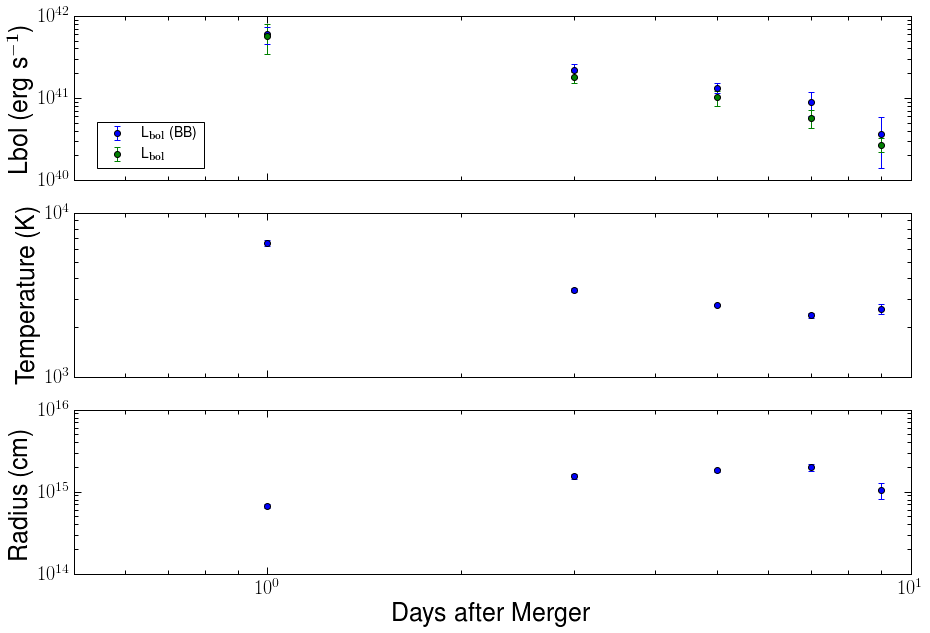

In [631]:
master_plot()

In [814]:
#sed_table(Villar)

# Summer Research

## Taking the code from Raf, we are now going to simulate light curves for LSST in the six following filters: u,g,r,i,z,y.

In [815]:
bands = ['u','g','r','i','z','y']
LSST_bandpasses = bandpasses('LSST Filters')
LSST_transmissions = interp_bandpasses(LSST_bandpasses)
LSST_lambdas = lambda_effectives(LSST_bandpasses)

def LSST_light_curves(times, simulated=False, gwsource=Villar):
    
    if simulated == True:
        blacks = BB_seds(times, ThreeComp)
        blues = BB_seds(times, Blue)
        purples = BB_seds(times, Purple)
        reds = BB_seds(times, Red)
        
        black_mags = LSST_magdict(blacks, times, gwsource, simulated)
        blue_mags = LSST_magdict(blues, times, gwsource, simulated)
        purple_mags = LSST_magdict(purples, times, gwsource, simulated)
        red_mags = LSST_magdict(reds, times, gwsource, simulated)

        return black_mags, blue_mags, purple_mags, red_mags

    else:
        data = [sed_data(gwsource, time) for time in times]
        dummy = [x.sort('lambda') for x in data]
        mags = LSST_magdict(data, times, gwsource, simulated)
        return mags       
    
    return



def LSST_magdict(sed_list, times, gwsource, simulated):
    mag_list = {band: [LSST_mags(sed_data, time, band, gwsource, simulated) for sed_data, time in zip(sed_list, times)] for band in bands}
    return Table([times,mag_list['u'],mag_list['g'],mag_list['r'],mag_list['i'],mag_list['z'],mag_list['y']],
                 names=('day','u','g','r','i','z','y'))
    
def LSST_mags(sed_data, time, band, gwsource, simulated):
    mag = 0
    sed_minlam = min(sed_data['lambda'])
    sed_maxlam = max(sed_data['lambda'])
    global sed_interp
    sed_interp = flux_interp(sed_data, band, simulated)
    #global sed_einterp
    #sed_einterp = flux_interp(sed_data, band)[1]
    lam_eff = LSST_lambdas['LSST '+band]
    LSST_lams = LSST_bandpasses['LSST '+band]
    global LSST_trans
    LSST_trans = LSST_transmissions['LSST '+band]
    LSST_minlam = min(LSST_lams['wavelength'])
    LSST_maxlam = max(LSST_lams['wavelength'])
    min_time = max(sed_minlam, LSST_minlam)
    max_time = min(sed_maxlam, LSST_maxlam)
    X = quad(flux_integral, min_time, max_time)[0]
    Y = quad(LSST_trans, min_time, max_time)[0]
    #X_sig = quad(eflux_integral, min_time, max_time)[0]
    #Y_sig = quad(LSST_trans, min_time, max_time)[0]
    #e_flux = X_sig/Y_sig
    
    if simulated == True:
        flux = X/Y
        mag = convert_to_mag(flux, lam_eff)
    else:
        upperlimits = upperlimit(gwsource[np.where(gwsource['band']==band)], 'magnitude')
        times = reset_days(upperlimits['reg days'], trigger)
        if time < max(times):
            flux = X/Y
            mag = convert_to_mag(flux, lam_eff)
        else:
            mag = np.inf
    return mag

def flux_interp(sed_data, band, simulated):
    if simulated == True:
        approx = 'cubic'
    else:
        if band in ['u','g','i','r','y']:
            approx = 'slinear'
        else:
            approx = 'cubic'
    #e_approx = 'linear'
    
    interp = interp1d(sed_data['lambda'], sed_data['flux']*1e-7, bounds_error=False, fill_value='extrapolate', kind=approx)
    #e_interp = interp1d(sed_data['lambda'], sed_data['e_flux']*1e-7, bounds_error=False, fill_value='extrapolate', kind=e_approx)
    return interp

def flux_integral(lam):
    return LSST_trans(lam)*sed_interp(lam)

def eflux_integral(lam):
    return LSST_trans(lam)*sed_einterp(lam)

def convert_to_mag(flux, lam_eff):
    c = astro.constants.c.to('Angstrom/s').value
    f_nu = (lam_eff**2/c)*flux
    #e_f_nu = (lam_eff**2/c)*e_flux
    mag = -2.5*np.log10(f_nu)-48.6
    #e_mag = 2.5/(np.log(10)*f_nu)*e_f_nu
    #abs_mag = mag-5*np.log10((40.7*1e6)/10)
    #abs_emag = e_mag
    return mag

## Villar Light Curves

In [816]:
Colors = ['blue', 'purple', 'red']

#Note: These dictionaries have lists that contain [mean, upperbound, lowerbound].
#Temperature (Temp) in Kelvin. Mass of ejecta (m_ej) in solar masses. Velocity of ejecta (v_ej) in fractions of c.
Temp = {'blue': [674.058, 416.996, 486.067], 'purple': [1307.972, 34.040, 42.067], 'red': [3745.062, 75.034, 75.337]}
m_ej = {'blue': [0.020, 0.001, 0.001], 'purple': [0.047, 0.001, 0.002], 'red': [0.011, 0.002, 0.001]}
v_ej = {'blue': [0.266, 0.008, 0.008], 'purple': [0.152, 0.005, 0.005], 'red': [0.137, 0.025, 0.021]}
Opacity = {'blue': 0.5, 'purple': 3, 'red':10}
Blue = np.asarray([m_ej['blue'][0], v_ej['blue'][0], Temp['blue'][0], Opacity['blue']])
Purple = np.asarray([m_ej['purple'][0], v_ej['purple'][0], Temp['purple'][0], Opacity['purple']])
Red = np.asarray([m_ej['red'][0], v_ej['red'][0], Temp['red'][0], Opacity['red']])
ThreeComp = np.asarray([Blue, Purple, Red]).flatten()
beta = 13.4
t_0 = 1.3
sigma = 0.11
M_sol_g = astro.units.solMass.to('g')
e_th_table = ascii.read('e_th_table.csv')
sig_sb = astro.constants.sigma_sb.cgs.value
c_cm = astro.constants.c.cgs.value

In [817]:
#
# Villar SED Creation
#

def BB_seds(times, param_list, dist = 40.7):
    '''
    Inputs:
    -> times - list of times measured in days
    
    -> param_list - a list containing lists of the following parameters: 
    
                    [EJECTA_MASS (M_sol), EJECTA_VELOCITY (c), CRITICAL_TEMPERATURE (K), OPACITY (cm/g)] (1)
                    Note: For multiple components, repeat (1) for each component and combine to a 1-D array
                    
    -> dist - gives the distance of the kilonova in Mpc

    Outputs:
    -> sed_table - sed tables which are used in the function LSST_light_curves() to plot the
                    magnitudes
    '''
    N = len(param_list)
    m_ejectas = [param_list[i] for i in range(0,N,4)]
    v_ejectas = [param_list[i] for i in range(1,N,4)]
    temps = [param_list[i] for i in range(2,N,4)]
    opacs = [param_list[i] for i in range(3,N,4)]
    tr_list = np.dstack([SED_sims(times, m_ej, v_ej, temp, opac) for m_ej, v_ej, temp, opac in zip(m_ejectas, v_ejectas, temps, opacs)])
    temp_list = tr_list[0]
    radii_list = tr_list[1]
    BBcolor = [BB_combinterp(temps, radii, dist) for temps, radii in zip(temp_list, radii_list)]
    sed_table = [Table([BBcolor[i][0], BBcolor[i][1], np.zeros(len(BBcolor[i][0]))],
                       names=('lambda', 'flux', 'e_flux')) for i in range(len(BBcolor))]
    return sed_table


def SED_sims(times, M_ej, V_ej, T_c, opac):
    '''
    Inputs:
    -> times - times; floats measured in seconds
    -> M_ej - ejecta mass; float measured in solar masses
    -> V_ej - ejecta velocity; float measured in fraction of c
    -> T_c - critical temperature for color component; float measured in K
    -> opac - color's opacity; float measured in cm^2/g
    
    
    Outputs:
    -> temperature - calculated temperature at time t; float measure in K
    -> radius - calculated radius at time t; float measured in cm
    '''
    t = times*86400
    
    Lbols = Lbol(t, M_ej, V_ej, opac)
    temps = T_photo(t, Lbols, V_ej, T_c)
    Temperatures = np.fromiter([max(temp, T_c) for temp in temps], float)
    Radii = R_photo(t, Lbols, V_ej, temps, T_c)
    return Temperatures, Radii



def BB_combinterp(temps, radii, dist = 40.7):
    steps = 1000
    min_lambda, max_lambda = LSST_range(LSST_bandpasses)
    lambdas = np.linspace(min_lambda, max_lambda, steps)
    fluxes = np.asarray([blackbody_function(lambdas, temp, radius, dist) for temp, radius in zip(temps, radii)])
    flux = fluxes.sum(axis=0)
    curve = np.array([lambdas, flux])
    return curve


def LSST_range(bandpasses):
    '''
    Inputs:
    -> bandpasses - dictionary containing the transmission curves of the six LSST filters
    
    Outputs:
    -> min_lambda, max_lambda - floats measured in Angstroms; the two lambdas give the range of wavelngths for BB_interp
    '''
    lam_list = []
    for key,table in bandpasses.items():
        lam_list.append(min(table['wavelength']))
        lam_list.append(max(table['wavelength']))
    return min(lam_list), max(lam_list)


def R_photo(times, lbols, v_ej, temps, T_c):
    '''
    Inputs:
    -> t - times; floats measured in seconds
    -> lbols - bolometric luminosities
    -> temp - calculated temperature at time t; float measured in K
    -> T_c - critical temperature for color component; float measured in K
    
    Outputs:
    -> radius - calculated radius at time t; float measured in cm
    '''
    radii = np.fromiter([(v_ej*c_cm)*t if temp > T_c else \
                         0 if np.isnan(lbol) else ((lbol)/(4*np.pi*sig_sb*T_c**4))**0.5 for t,lbol,temp in zip(times, lbols, temps)],
                        float)
    return radii

def T_photo(times, lbols, v_ej, T_c):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> opacity - color's opacity; float measured in cm^2/g
    -> T_c - critical temperature for color component; float measured in K
    
    Outputs:
    -> temp - calculated temperature at time t; float measured in K
    '''
    temps = np.fromiter([T_c if np.isnan(lbol) else ((lbol)/(4*np.pi*sig_sb*((v_ej*c_cm)*t)**2))**0.25 for t,lbol in zip(times, lbols)],
                        float)
    
    return temps

def Lbol(t, m_ej, v_ej, opacity):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> opacity - color's opacity; float measured in cm^2/g
    
    Outputs:
    -> lbol - calculated bolometric luminosity at time t; float measured in erg/s
    '''
    T_d = t_d(m_ej, v_ej, opacity)
    lbol = (2*np.exp(-1.*((t/T_d)**2))/T_d)*Lbol_integral(t, m_ej, v_ej, T_d)
    return lbol

def t_d(m_ej, v_ej, opacity):
    '''
    Inputs:
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> opacity - color's opacity; float measured in cm^2/g
    
    Outputs:
    -> t_d - calculated value of t_d (see Villar paper); float measured in seconds
    '''
    return np.sqrt((2*(opacity)*(m_ej*M_sol_g))/(beta*(v_ej*c_cm)*c_cm))

def Lbol_integral(times, m_ej, v_ej, t_d):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> t_d - calculated value of t_d (see Villar paper); float measured in seconds
    
    Outputs:
    -> lbol_int - the integral part of Lbol() (see Villar paper); no useful output on its own, but measured in erg/s
    '''
    
    return np.fromiter([quad(L_integrand, 0, t, args=(m_ej, v_ej, t_d))[0] for t in times], float)

def L_integrand(t, m_ej, v_ej, t_d):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    -> t_d - calculated value of t_d (see Villar paper); float measured in seconds
    
    Outputs:
    -> l_integrand - the integrand of Lbol_integral() (see Villar paper); no useful output on its own, but measured in erg/s.
    '''
    return L_in(t, m_ej)*e_th(t, m_ej, v_ej)*np.exp((t/t_d)**2)*(t/t_d)

def L_in(t, m_ej):
    '''
    Inputs:
    -> t - time; float measured in seconds
    -> m_ej - ejecta mass; float measured in solar masses
    
    Outputs:
    -> l_in - function used in Lbol() (see Villar paper); units of erg/s
    '''
    return 4e18*(m_ej*M_sol_g)*(0.5-(1/np.pi)*np.arctan((t-t_0)/sigma))**1.3

def e_th(time, m_ej, v_ej):
    '''
    Inputs:
    -> t - time; float measured in seconds
        Note: the time for e_th(t must be measured in days)
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    
    Outputs:
    -> e_th - function used in Lbol() (see Villar paper); it is a float X such that 0 < X < 1.
    '''
    t = time/86400
    a,b,d = calc_coeffs(m_ej, v_ej)
    return 0.36*(np.exp(-a*t)+(np.log(1+2*b*t**d)/(2*b*t**d)))

def calc_coeffs(m_ej, v_ej):
    '''
    Inputs:
    -> m_ej - ejecta mass; float measured in solar masses
    -> v_ej - ejecta velocity; float measured in fraction of c
    
    Outputs:
    -> coeffs_list - array containing lists of the coefficiencts a, b, and d. 
                     Note: Each coefficient has three different values [i_rand, i_rad, i_tor] for i in {a,b,d}; rand, rad, and tor are
                            different measurements for a, b, and d depending on the data points used (see Barnes et al. 2016).
    '''
    
    a_interps = e_th_interps('a')
    b_interps = e_th_interps('b')
    d_interps = e_th_interps('d')
    
    a_list = a_interps([m_ej, v_ej])[0]
    b_list = b_interps([m_ej, v_ej])[0]
    d_list = d_interps([m_ej, v_ej])[0]
        
    return [a_list, b_list, d_list]

def e_th_interps(coeff):
    '''
    Input:
    -> coeff - string representing the coefficient a, b, and d
    
    Output:
    e_th_interps - a 2D interpolation for a coefficient; interpolations are dependent on ejecta mass and velocity
                   Note: there are three interpolations for one component: random (rand), radial (rad), and toroidal (tor);
                           see Barnes et al. 2016 for more explanation.
    '''
    function = 'linear'
    v_ej = np.asarray([0.1, 0.2, 0.3])
    m_ej = np.asarray([1.e-3, 5.e-3, 1.e-2, 5.e-2])
    
    if coeff == 'a':
        coeffs = np.asarray([[2.01, 4.52, 8.16], [0.81, 1.9, 3.2], [
                              0.56, 1.31, 2.19], [.27, .55, .95]])
    elif coeff == 'b':
        coeffs = np.asarray([[0.28, 0.62, 1.19], [0.19, 0.28, 0.45], [
                              0.17, 0.21, 0.31], [0.10, 0.13, 0.15]])
    else:
        coeffs = np.asarray([[1.12, 1.39, 1.52], [0.86, 1.21, 1.39], [
                              0.74, 1.13, 1.32], [0.6, 0.9, 1.13]])
    
    interp = RegularGridInterpolator((m_ej, v_ej), coeffs, method=function)
    
    return interp

In [818]:
LSST = LSST_light_curves(np.linspace(1.06,15.85,30))

In [819]:
LSST_black, LSST_blue, LSST_purple, LSST_red = LSST_light_curves(np.linspace(0.1,15,100), simulated=True)

The GW source has the following filters:

['i', 'H', 'r', 'Ks', 'J', 'V', 'z', 'W', 'g', 'w', 'Y', 'M2', 'W1', 'U', 'W2', 'y', 'B', 'I', 'R', 'K', 'u', 'J1', 'F110W', 'F160W', 'F336W', 'J8.9', 'F606W', 'F475W', 'F625W', 'F775W', 'F850W', 'F814W', 'F225W', 'F275W']

Do you wish to plot in magnitude or flux?
Choose filters to plot (e.g. u,g,r,i,z):


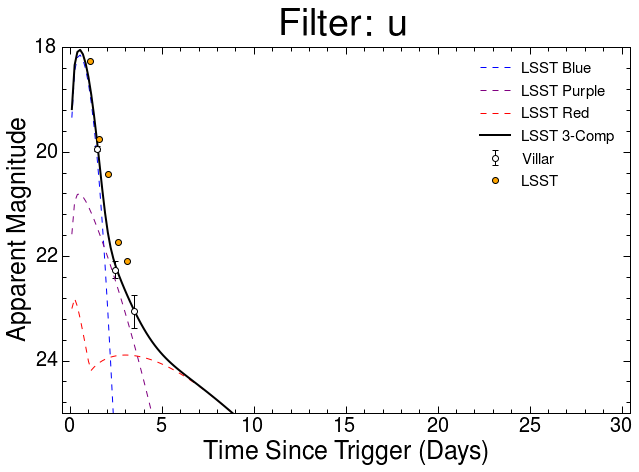

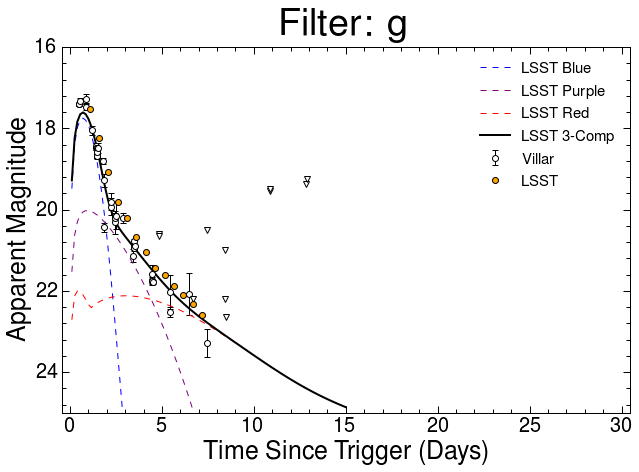

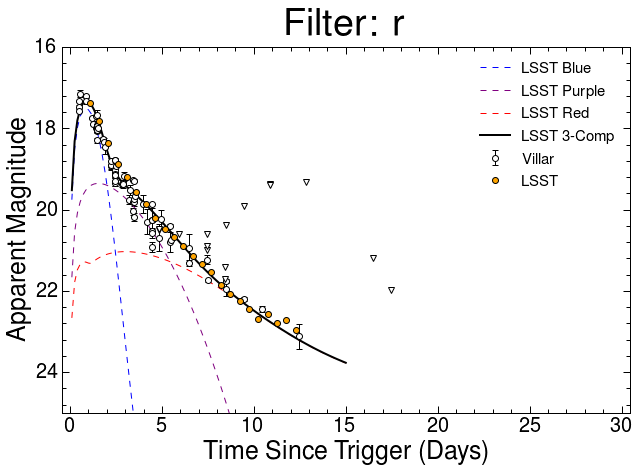

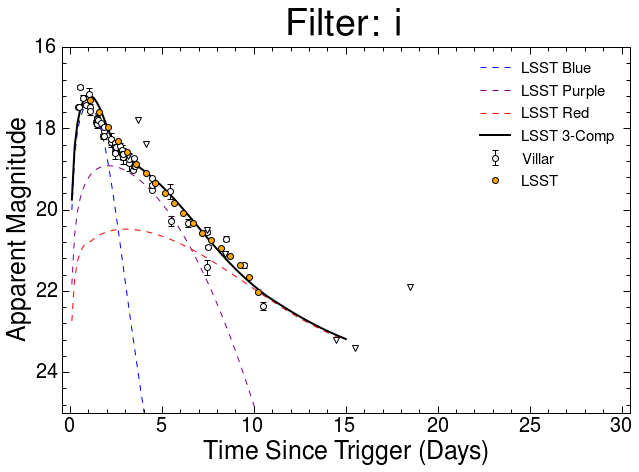

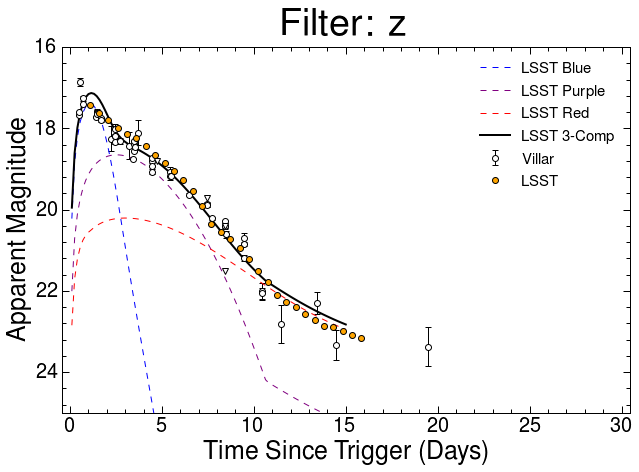

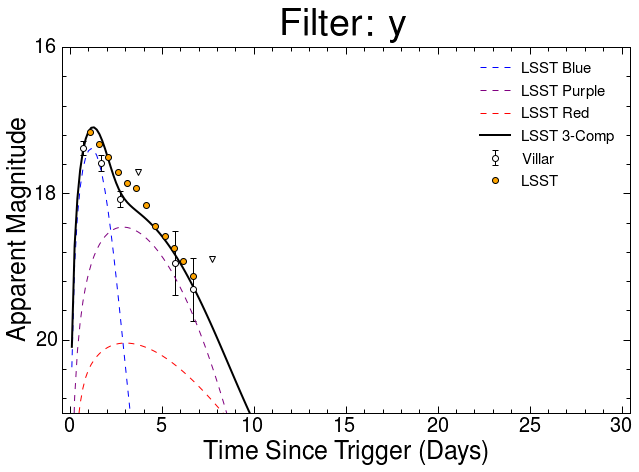

In [823]:
plot_light_curve(Villar)

## Likelihood Calculations

In [789]:
def kilonova_simulation(times, params, dist, model = True):
    seds = BB_seds(times, params, dist)
    mag_table = LSST_magdict(seds, times, Villar, True)
    if model == True:
        light_curves = mag_table
    else:
        model_lc = check_mags(mag_table)
        sigmas = calc_sigmas(model_lc)
        random_obs = rand_mags(model_lc, sigmas)
        light_curves = [random_obs, sigmas]
    return light_curves

def check_mags(mag_table):
    new_mags = {band: [np.inf if mag > kilonova.m_5(band, kilonova.parameters) \
                     else mag for mag in mag_table[band]] for band in bands}
    return Table([mag_table['day'],new_mags['u'],new_mags['g'],new_mags['r'],new_mags['i'],new_mags['z'],new_mags['y']],
                 names=('day','u','g','r','i','z','y'))

def calc_sigmas(model_lc):
    sigmas = {band: [np.inf if mag > kilonova.m_5(band, kilonova.parameters) \
                     else kilonova.sigma_1(mag, band) for mag in model_lc[band]] for band in bands}
    return Table([model_lc['day'],sigmas['u'],sigmas['g'],sigmas['r'],sigmas['i'],sigmas['z'],sigmas['y']],
                 names=('day','u','g','r','i','z','y'))

def rand_mags(obs_lc, sigmas):
    #np.random.normal(obs_lc[band], sigmas[band])
    obs = {band: obs_lc[band] for band in bands}
    return Table([obs_lc['day'],obs['u'],obs['g'],obs['r'],obs['i'],obs['z'],obs['y']],
                 names=('day','u','g','r','i','z','y'))

def calc_likelihoods(model_params, obs_params, times, dist):
    likelihoods = [calc_likelihood(model_param, obs_params, times, dist) for model_param in model_params]
    return likelihoods

def calc_likelihood(model_param, obs_params, times, dist):
    observation = kilonova_simulation(times, obs_params, dist, model = False)
    model = kilonova_simulation(times, model_param, dist, model = True)
    likelihood = calc_likes(observation, model)
    return likelihood

def calc_likes(observation, model):
    Observation = np.asarray([observation[0][band][np.isfinite(observation[0][band])] for band in bands])
    Sigma = np.asarray([observation[1][band][np.isfinite(observation[0][band])] for band in bands])
    Model = np.asarray([model[band][np.isfinite(observation[0][band])] for band in bands])
    Lengths = np.asarray([min(len(Observation[i]), len(Model[i])) for i in range(len(bands))])
    Likelihoods = like_total(Observation, Sigma, Model, Lengths)
    return Likelihoods
    
def like_total(observation, sigmas, model, lengths):
    obs = np.hstack(np.asarray([observation[i][:lengths[i]] for i in range(len(lengths))]))
    sig = np.hstack(np.asarray([sigmas[i][:lengths[i]] for i in range(len(lengths))]))
    mod = np.hstack(np.asarray([model[i][:lengths[i]] for i in range(len(lengths))]))
    return loglike(obs, sig, mod)

def loglike(obs_mag, obs_sig, model_mag):
    ln_like = -0.5*np.sum(((obs_mag-model_mag)**2/(obs_sig**2))-np.log(2*np.pi*obs_sig**2))
    return -1.*ln_like/1e3


def Optimal_Parameters(model_param, obs_params, times, dist):
    bnds = ((0.001, 0.05), (0.1, 0.3), (0,None), (0, None))
    opt_params = minimize(calc_likelihood, model_param, args=(obs_params,times, dist), bounds=bnds, method='SLSQP')
    return opt_params

In [27]:
Col = 'blue'
model0 = [0.04, 0.2, 2000, Opacity[Col]]
model1 = [0.035, 0.25, 1800, Opacity[Col]]
model2 = [0.03, 0.15, 2600, Opacity[Col]]
dist = 100
Times = np.linspace(0.1,10,10)

In [769]:
obs = kilonova_simulation(Times, model0, dist, model = False)
modelone = kilonova_simulation(Times, model1, dist, model = True)
modeltwo = kilonova_simulation(Times, model2, dist, model = True)
modelthree = kilonova_simulation(Times, model3, dist, model = True)

In [29]:
Obs = kilonova_simulation(Times, model0, dist, model = True)

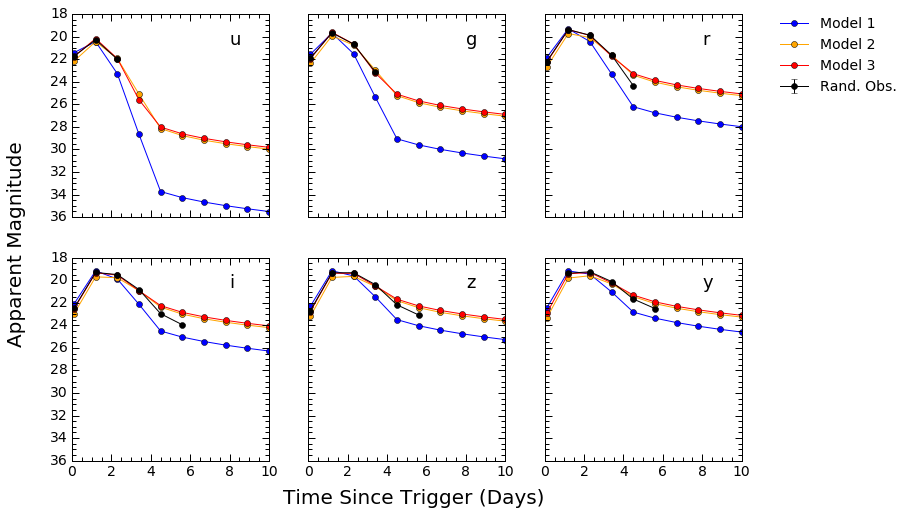

In [772]:
majorFormatter = FormatStrFormatter('%d')
majorLocatorx = MultipleLocator(2)
majorLocatory = MultipleLocator(2)
minorLocatorx = MultipleLocator(1)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
f.set_figheight(8)
f.set_figwidth(12)
f.text(0.52, 0.05, 'Time Since Trigger (Days)', ha='center', fontsize=axeslabelsize-5)
f.text(0.05, 0.5, 'Apparent Magnitude', va='center', rotation='vertical', fontsize=axeslabelsize-5)
plt.gca().invert_yaxis()
for band, ax in zip(bands, [ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.errorbar(obs[0]['day'], obs[0][band], yerr=obs[1][band], fmt='o-', color='black', label='Rand. Obs.')
    ax.plot(modelone['day'], modelone[band], 'o-', color='Blue', label='Model 1')
    ax.plot(modeltwo['day'], modeltwo[band], 'o-', color='Orange', label='Model 2')
    ax.plot(modelthree['day'], modelthree[band], 'o-', color='Red', label='Model 3')
    ax.text(0.8, 0.85, band, fontsize=18, transform=ax.transAxes)
    
    plt.xlim(0,10)
    ax.tick_params(labelsize=tickfontsize-6)
    plt.yticks(fontsize=tickfontsize) 
    ax.xaxis.set_major_locator(majorLocatorx)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_major_locator(majorLocatory)
    ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.legend(numpoints=1, fontsize=legend-3, frameon=False, bbox_to_anchor=(1.85,2.25))
plt.show()

In [791]:
Optimal_Parameters(model1, model2, Times, 100)

     fun: 0.14389648138403044
     jac: array([ -1.49480224e+00,   2.76562056e-01,  -7.86595047e-06,
        -3.77688222e-02])
 message: 'Optimization terminated successfully.'
    nfev: 204
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([  2.99999721e-02,   1.49999861e-01,   2.59999978e+03,
         4.99999985e-01])

In [786]:
Optimal_Parameters(model1, model0, Times, 100)

     fun: 0.11734498225058831
     jac: array([ -5.56963800e-01,   1.24391011e-01,   2.01817602e-06,
        -8.26925784e-03])
 message: 'Optimization terminated successfully.'
    nfev: 159
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([  3.99998994e-02,   2.00001040e-01,   2.00010484e+03,
         5.00003165e-01])

In [782]:
model1

[0.035, 0.25, 1800, 0.5]

In [767]:
model0

[0.04, 0.2, 2000, 0.5]

## LSST Time of Observation

In [615]:
from itertools import product
samptime = np.linspace(0.1,10,10)
mags_dict = {'u': np.array([np.inf, 22.0, 23.68, 25.0]), 'g': np.array([21.0, 23.7, 24.89, 26.0]), 'r': np.array([20.44, 23.3, 24.43, 25.4]),
             'i': np.array([19.72, 22.9, 24.0, 25.0]), 'z': np.array([np.inf, 22.2, 23.45, 24.4]), 'y': np.array([np.inf, 20.9, 22.6, 23.4])}

ZTF = np.array([np.inf, 21.0, 20.44, 19.72, np.inf, np.inf])
DECam = np.array([22.0, 23.7, 23.3, 22.9, 22.2, 20.9])
LSST = np.array([23.68, 24.89, 24.43, 24.0, 23.45, 22.6])
LSSTlong = np.array([25.0, 26.0, 25.4, 25, 24.4, 23.4])
# 0.005, 0.01, 0.05 m_red
# m_blue = 0.5m_red
mass_red = np.geomspace(0.005,0.05,7)#np.array([0.005, 0.01, 0.05])
# 60% increase from v_blue to v_red
# v_blue = 1.5v_red
# v_red = 0.1, 0.15, 0.2 
velocities_red = np.linspace(0.1,0.3,7)
distances = np.linspace(30,300,7)
temperature_red = np.array([1200])
opacity_red = np.array([Opacity['red']])
test_sample = np.asarray(list(product(mass_red, velocities_red, temperature_red, opacity_red, distances)))

In [606]:
def twocomp_sample(params):
    return np.asarray([twocomplist(param) for param in params])

def twocomplist(param):
    m_red, v_red, T_red, opac_red, dist = param
    T_blue = 4000
    opac_blue = Opacity['blue']
    
    m_blue = 0.5*m_red
    if m_blue > 0.05:
        m_blue = 0.05
    elif m_blue < 0.001:
        m_blue = 0.001
    else:
        m_blue = m_blue
    
    
    v_blue = 1.5*v_red
    if v_blue > 0.3:
        v_blue = 0.3
    elif v_blue < 0.1:
        v_blue = 0.1
    else:
        v_blue = v_blue
    
    
        
    return np.array([m_red, v_red, T_red, opac_red, m_blue, v_blue, T_blue, opac_blue, dist])
    

In [607]:
twocomp_test = twocomp_sample(test_sample)

In [608]:
def kilonovae(times, param_list):
    if param_list.ndim == 1:
        params = np.array([param_list[:len(param_list)-1]])
        dists = np.array([param_list[len(param_list)-1]])
    else:
        params = param_list[:,:len(param_list[0])-1]
        dists = param_list[:,len(param_list[0])-1]
    kilonovae = [kilonova_simulation(times, param, dist, model = True) for param,dist in zip(params, dists)]
    
    return kilonovae

def time_tables(maglist, times, kilonovae):
    timetablelist = [time_table(maglist, times, kilonova) for kilonova in kilonovae]
    timedict = {band:[timetable[band] for timetable in timetablelist] for band in bands}
    return timedict

def time_table(mag_list, times,  kilonova):
    time_dict = {band: calc_time(mag, times, kilonova[band]) for band,mag in zip(bands,mag_list)}
    return time_dict


def calc_time(mag, times, magnitudes):
    if mag < min(magnitudes) or mag == np.inf:
        time = 0
    else:
        mag_interp = interp1d(times, magnitudes-mag, bounds_error=False, fill_value='extrapolate')
        mag_check = interp1d(times, magnitudes, bounds_error=False, fill_value='extrapolate')
        time_options = np.asarray([fsolve(mag_interp, time) for time in times])
        time = check_times(time_options, mag_check, mag)
    return time

def check_times(times, mag_check, mag):
    mags = np.asarray([mag_check(time) for time in times])
    time = times[np.where(mags == mag)]
    return max(time)


def compare_thresholds(times, kilonovae, threshold):
    table_list = [time_tables(maglist, samptime, kilonovae) for maglist in [ZTF, DECam, LSST, LSSTlong]]
    percent_list = [calcpercentage(table, threshold) for table in table_list]
    return percent_list
    

In [616]:
Kilonovae = kilonovae(samptime, test_sample)

In [610]:
Kilonovaetwo = kilonovae(samptime, twocomp_test)

In [478]:
Time_table = time_tables(ZTF, samptime, Nova)

In [365]:
Time_tabletwo = time_tables(LSST, samptime, Kilonovaetwo)

In [618]:
compare_thresholds(samptime, Kilonovae, 5)

[0.0, 3.9844509232264333, 8.9893100097181726, 15.451895043731778]

In [621]:
compare_thresholds(samptime, Kilonovaetwo, 5)

[0.68027210884353739,
 14.139941690962099,
 27.89115646258503,
 44.752186588921283]

In [623]:
len(twocomp_test)

343

In [172]:
def calcpercentage(timetable, threshold):
    nums = [calcthreshold(timetable[band], threshold) for band in bands]
    tots = [len(timetable[band]) for band in bands]
    percent = 100*np.divide(np.sum(nums), np.sum(tots))
    return percent

def calcthreshold(timelist, threshold):
    num = 0
    for time in timelist:
        if time >= threshold:
            num +=1
        else:
            num = num
    return num

In [39]:
def plt_total(time_tables, kilonovae): 
    majorFormatter = FormatStrFormatter('%d')
    majorLocatorx = MultipleLocator(2)
    majorLocatory = MultipleLocator(2)
    minorLocatorx = MultipleLocator(1)
    mag_points = ['^', 's', 'P', 'D', 'X']
    mag_list = ['20', '21', '22', '23', '24']
    values = range(len(kilonovae))
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap1 = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('gist_rainbow'))
    for i in values:
        f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
        f.set_figheight(8)
        f.set_figwidth(15)
        f.text(0.52, 0.05, 'Time Since Trigger (Days)', ha='center', fontsize=axeslabelsize-5)
        f.text(0.05, 0.5, 'Apparent Magnitude', va='center', rotation='vertical', fontsize=axeslabelsize-5)
        plt.gca().invert_yaxis()
        for band, ax in zip(bands, [ax1,ax2,ax3,ax4,ax5,ax6]): 
            ax.plot(kilonovae[i]['day'], kilonovae[i][band], 'o-', color=scalarMap1.to_rgba(values[i]), alpha = 0.5, label='Model '+str(i+1))
            
            [ax.plot([], [], mag_points[j], color='black', label = 'Mag: '+mag_list[j]) 
             for j in range(len(mag_list))]
            ax.plot([],[],'>', color='white', markersize=8, markeredgewidth=1,
                    label = 't$_{\\mathrm{\\mathsf{obs}}}$ $>$ 10 days')
            
            handles, labels = ax.get_legend_handles_labels()
            
            [ax.plot(time_tables[i][band][j], time_tables[i]['mag'][j], mag_points[j], color='black', label = None) 
             for j in np.where((time_tables[i][band] !=0) & (time_tables[i][band] <= 10))[0]]
            
            
            
            [ax.plot([10],time_tables[i]['mag'][j], 
                     '>', color='white', markersize=8, markeredgewidth=1, label = None) 
             for j in np.where((time_tables[i][band] !=0) & (time_tables[i][band] > 10))[0]]
            
            
            
            [ax.plot(np.linspace(-0.5,10.5,10),np.full(10, time_tables[i]['mag'][j]), 
                     ':', color='black', alpha=0.7, label = None) for j in np.where(time_tables[i][band] !=0)[0]]
            
            ax.text(0.485, 1.05, band, fontsize=18, transform=ax.transAxes)

            plt.xlim(-0.5,10.5)
            ax.tick_params(labelsize=tickfontsize-6)
            plt.yticks(fontsize=tickfontsize) 
            ax.xaxis.set_major_locator(majorLocatorx)
            ax.xaxis.set_major_formatter(majorFormatter)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
            ax.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
            ax.yaxis.set_major_formatter(majorFormatter)
            ax.yaxis.set_major_locator(majorLocatory)
            ax.yaxis.set_minor_locator(AutoMinorLocator())
        
        
        plt.ylim(26, np.floor(min([min(kilonovae[i][band]) for band in bands]))-0.5)
        plt.legend(handles, labels, numpoints=1, fontsize=legend-3, frameon=False, bbox_to_anchor=(1.75,2.25))
        plt.show()
    return

SCALE = 50

def display_times(param_list, time_tables):
    majorFormatter = FormatStrFormatter('%.2f')
    majorLocatorx = MultipleLocator(0.1)
    majorLocatory = MultipleLocator(0.01)
    minorLocatory = MultipleLocator(0.005)
    
    f = plt.figure(figsize=(25, 20))
    GS = gridspec.GridSpec(2, 1, height_ratios = [3.85, 0.15])
    
    gs = gridspec.GridSpecFromSubplotSpec(5, 6, subplot_spec=GS[0], hspace=0.05, wspace=0.05) 
    gss = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=GS[1], width_ratios = [1, 1], hspace=0.05, wspace=0.05)
    Ax1 = plt.subplot(gss[0])
    Ax2 = plt.subplot(gss[1])
    
    ax1, ax2, ax3, ax4, ax5, ax6 = [plt.subplot(gs[i]) for i in range(6)]
    bx1, bx2, bx3, bx4, bx5, bx6 = [plt.subplot(gs[i]) for i in range(6,12)]
    cx1, cx2, cx3, cx4, cx5, cx6 = [plt.subplot(gs[i]) for i in range(12,18)]
    dx1, dx2, dx3, dx4, dx5, dx6 = [plt.subplot(gs[i]) for i in range(18,24)]
    ex1, ex2, ex3, ex4, ex5, ex6 = [plt.subplot(gs[i]) for i in range(24,30)]
    [plt.setp(ax.get_yticklabels(), visible=False) for ax in [ax2, ax3, ax4, ax5, ax6,
                                                              bx2, bx3, bx4, bx5, bx6,
                                                              cx2, cx3, cx4, cx5, cx6,
                                                              dx2, dx3, dx4, dx5, dx6,
                                                              ex2, ex3, ex4, ex5, ex6]]
    [plt.setp(ax.get_xticklabels(), visible=False) for ax in [ax1, ax2, ax3, ax4, ax5, ax6,
                                                              bx1, bx2, bx3, bx4, bx5, bx6,
                                                              cx1, cx2, cx3, cx4, cx5, cx6,
                                                              dx1, dx2, dx3, dx4, dx5, dx6]]
    f.text(0.515, 0.935, 'Filter', ha='center', fontsize=axeslabelsize)
    f.text(0.935, 0.564, 'Magnitude', va='center', rotation=270, fontsize=axeslabelsize)
    
    subplots = [[ax1, ax2, ax3, ax4, ax5, ax6],
                [bx1, bx2, bx3, bx4, bx5, bx6],
                [cx1, cx2, cx3, cx4, cx5, cx6],
                [dx1, dx2, dx3, dx4, dx5, dx6],
                [ex1, ex2, ex3, ex4, ex5, ex6]]
    
    Times = [2, 4, 6, 8, 10]
    for time in Times:
        Ax1.scatter([], [], c='k', s=time*SCALE,
                label=str(time) + ' Days')
        
    Ax1.set_axis_off()
    Ax1.set_frame_on(False)        
    handles, labels = Ax1.get_legend_handles_labels()
    Ax1.legend(handles, labels, scatterpoints=1, frameon=True, fontsize=legend, ncol=5, columnspacing=1, handletextpad=0.1,
               loc='center')

    for ax in [ax1,ax2,ax3,ax4,ax5,ax6,bx1,bx2,bx3,bx4,bx5,bx6,cx1,cx2,cx3,cx4,cx5,cx6,dx1,dx2,dx3,dx4,dx5,dx6,ex1,ex2,ex3,ex4,ex5,ex6]:
        ax.tick_params(labelsize=tickfontsize-5)
        ax.set_xlim(0.08,0.32)
        ax.set_ylim(-0.005,0.055)
        ax.xaxis.set_major_locator(majorLocatorx)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='major',length=majorticklength-2, width=majortickwidth, colors='k')
        ax.tick_params(which='minor',length=minorticklength-1, width=minortickwidth, colors='k')
        ax.yaxis.set_major_locator(majorLocatory)
        ax.yaxis.set_minor_locator(minorLocatory)
    
    for ax in [ax1,bx1,cx1,dx1,ex1]:
        ax.set_ylabel('m$_{\\mathsf{ej}} \ (\\mathsf{M}_\\mathbf{\odot})$', fontsize=axeslabelsize)
        
    for ax in [ex1,ex2,ex3,ex4,ex5,ex6]:
        ax.set_xlabel('$\\mathbf{\\nu}_{\\mathsf{ej}} \ (\\mathsf{c})$', fontsize=axeslabelsize)
        
    for ax,band in zip([ax1,ax2,ax3,ax4,ax5,ax6],bands):
        ax.xaxis.set_label_position('top')
        ax.xaxis.labelpad = 10
        ax.set_xlabel(band, fontsize=axeslabelsize)
        
    for ax,mag in zip([ax6,bx6,cx6,dx6,ex6],maglist):
        ax.yaxis.set_label_position('right')
        ax.yaxis.labelpad = 15
        ax.set_ylabel(str(mag), fontsize=axeslabelsize, va='center', rotation=270)
        
        
    points = mvtlist(param_list, time_tables)
    [plt_band(axs, mag, points) for axs, mag in zip(subplots,['20','21','22','23','24'])] 
    
    cmap = matplotlib.cm.viridis_r
    norm = matplotlib.colors.Normalize(vmin=30, vmax=300)

    cb1 = matplotlib.colorbar.ColorbarBase(Ax2, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
    cb1.set_label('Distance (Mpc)', fontsize=tickfontsize-2)
    cb1.ax.tick_params(labelsize=tickfontsize-4) 
    
    plt.show()
    return


def plt_band(axs, mag, points):
    [plt_mag(ax, mag, band, points) for ax,band in zip(axs,bands)]
    return

def plt_mag(ax, mag, band, points):
    data = np.asarray([points[i][band][mag] for i in range(len(points))])
    distances = data[:,2]
    data_new = np.asarray(np.split(np.flip(np.split(data,len(distances)/len(np.unique(distances))),0).flatten(), len(data)))
    masses = data_new[:,0]
    velocities = data_new[:,1]
    distances_new = data_new[:,2]
    times = data_new[:,3]
    
    ax.scatter(velocities, masses, s=times*SCALE, c=distances_new, cmap="viridis_r", edgecolors="black", linewidth=1)
    return



In [40]:
def mvtlist(param_list, timetables):
    table_lists = [[param_list[:,0][i], param_list[:,1][i], param_list[:,len(param_list[0])-1][i],
                    timetables[i]] for i in range(len(timetables))]
    time_list = [get_timelist(table_list) for table_list in table_lists]
    return time_list

def get_timelist(table_list):
    mass, vel, dist, table = table_list
    return {band: ordermags(mass, vel, dist, table, band) for band in bands}

def ordermags(mass, vel, dist, table, band):
    return {str(mag): [mass, vel, dist, float(table[band][np.where(table['mag'] == mag)])] for mag in table['mag']}

In [493]:
def mvtklist(param_list, kilonovae):
    table_lists = [[param_list[:,0][i], param_list[:,1][i], param_list[:,len(param_list[0])-1][i],
                    kilonovae[i]] for i in range(len(param_list))]
    time_list = [get_mvtklist(table_list) for table_list in table_lists]
    return time_list

def get_mvtklist(table_list):
    mass, vel, dist, kilonova = table_list
    return {band: [mass, vel, dist, np.asarray(kilonova[band])] for band in bands}

In [51]:
dist_len = len(distances)
vel_len = len(velocities_red)
total_plots = vel_len*dist_len

In [401]:
x = mvtklist(test_sample, Nova)

In [529]:
mags_dict = {'u': np.array([np.inf, 22.0, 23.68, 25.0]), 'g': np.array([21.0, 23.7, 24.89, 26.0]), 'r': np.array([20.44, 23.3, 24.43, 25.4]),
             'i': np.array([19.72, 22.9, 24.0, 25.0]), 'z': np.array([np.inf, 22.2, 23.45, 24.4]), 'y': np.array([np.inf, 20.9, 22.6, 23.4])}

def tick_parameters(Axs, band, kilonovae):
    majorLocatorx = MultipleLocator(2)
    majorLocatory = MultipleLocator(2)
    minorLocatory = MultipleLocator(1)
    uplims = [0.5,0.5,0.5,0.5,0.5,0.5]
    lowlim = 1.5
    
    for ax in Axs:
        plt.gca().invert_yaxis()
        ax.tick_params(labelsize=tickfontsize-5)
        ax.set_xlim(-0.5,10.5)
        ax.set_ylim(np.ceil(max(mags_dict[band][np.where(np.isfinite(mags_dict[band]))]))+lowlim,
                    np.floor(min([min(kilonovae[i][band]) for i in range(len(kilonovae))]))-uplims[bands.index(band)])
        ax.xaxis.set_major_locator(majorLocatorx)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='major',length=majorticklength-2, width=majortickwidth, colors='k')
        ax.tick_params(which='minor',length=minorticklength-1, width=minortickwidth, colors='k')
        ax.yaxis.set_major_locator(majorLocatory)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    return


def velocity_text(Axs):
    dist_len = len(distances)
    vel_len = len(velocities_red)
    total_plots = vel_len*dist_len
    for ax,vel in zip([Axs[int((i*total_plots/vel_len)-1)] for i in range(vel_len)],velocities_red):
        ax.yaxis.set_label_position('right')
        ax.yaxis.labelpad = 25
        ax.set_ylabel('$\\mathbf{\\nu}_{\\mathsf{ej}}$ = '+str(vel)+'c', fontsize=tickfontsize, rotation=270)
    return

def plot_curves(light_curve, axes):
    band_plots = [plot_band(light_curve[band], axes[i], band) for band,i in zip(bands,range(6))]
    return

def plot_band(params, ax_list, band):
    dist_len = len(distances)
    vel_len = len(velocities_red)
    total_plots = vel_len*dist_len
    mass, velocity, distance, mags = params
    if distance in distances:
        list_index = list(np.where(distances == distance)[0])[0]
        plot = plt_vels(mass, velocity, mags, [ax_list[i] for i in range(list_index,total_plots,4)], band)
    return

def plt_vels(mass, velocity, mags, Ax, band):
    dist_len = len(distances)
    vel_len = len(velocities_red)
    total_plots = vel_len*dist_len
    if velocity in velocities_red:
        list_index = list(np.where(velocities_red == velocity)[0])[0]
        plot = plt_mass(mass, mags, Ax[list_index], band)
    return plot

def plt_mass(mass, mags, ax, band):
    if mass == 0.005:
        plot = plt_plot(mags, ax, 'Green', band)
    elif mass == 0.01:
        plot = plt_plot(mags, ax, 'Orange', band)
    elif mass == 0.05:
        plot = plt_plot(mags, ax, 'Blue', band)
    return

def plt_plot(mags, ax, color, band):
    lim_styles = [':','--','-']
    ax.plot(samptime, mags, 'o-', color=color, alpha = 0.45)  

    [ax.plot(np.linspace(-0.5,10.5,10),np.full(10, mags_dict[band][i]), lim_styles[i], color='black', linewidth=1.5, label = None)
     for i in range(len(mags_dict[band][:2]))]
    
    ax.plot(np.linspace(-0.5,10.5,10),np.full(10, mags_dict[band][2]), lim_styles[2], color='black', linewidth=1.5, label = None)
    #ax.plot(np.linspace(-0.5,10.5,10),np.full(10, mags_dict[band][3]), lim_styles[2], color='Purple', alpha = 0.3, linewidth=1.5, label = None)
    return

In [533]:
def plt_results(param_list, kilonovae):
    dist_len = len(distances)
    vel_len = len(velocities_red)
    total_plots = vel_len*dist_len

    f = plt.figure(figsize=(20, 15))
    GS = gridspec.GridSpec(2, 1, hspace=0.3, height_ratios=[20, 1])
    gs = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=GS[0], hspace=0.07, wspace=0.25)
    gs1 = [gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=GS[1])]
    gss = [gridspec.GridSpecFromSubplotSpec(vel_len, dist_len, subplot_spec=gs[i], hspace=0.09, wspace=0.09) for i in range(6)]

    axes = np.asarray([[plt.subplot(gss[i][j]) for j in range(total_plots)] for i in range(6)])
    AXIS = np.asarray([plt.subplot(gs1[0][0])])

    [plt.setp(ax.get_yticklabels(), visible=False)
     for ax in [axes[i][j] for j in [i for i in range(total_plots) if i not in range(0,total_plots,4)] for i in range(6)]]
    [plt.setp(ax.get_xticklabels(), visible=False) for ax in [axes[i][j] for j in range(total_plots) for i in range(4)]]
    [plt.setp(ax.get_xticklabels(), visible=False) for ax in [axes[i][j] for j in range(total_plots-dist_len) for i in range(4,6)]]
    
    AXIS[0].set_axis_off()
    AXIS[0].set_frame_on(False)        
    for ax in AXIS:
        ax.plot([],[],'o-', color='Green', label='m$_{\\mathsf{ej}}$ = 0.005$\\mathsf{M}_\\mathbf{\odot}$')
        
        ax.plot([],[],'o-', color='Orange', label='m$_{\\mathsf{ej}}$ = 0.01$\\mathsf{M}_\\mathbf{\odot}$')
        
        ax.plot([],[],'o-', color='Blue', label='m$_{\\mathsf{ej}}$ = 0.05$\\mathsf{M}_\\mathbf{\odot}$')
        
        #ax.plot([],[],'o-', markerfacecolor='None', markeredgecolor='None', linestyle = 'None', label=' ')
        ax.plot([],[], color='black', dashes=[2, 3], linewidth=1.5, label='ZTF')
        ax.plot([],[],'--', color='black', dashes=[4, 3], linewidth=1.5, label='DECam')
        ax.plot([],[],'-', color='black', linewidth=2, label='LSST')
        #ax.plot([],[],'-', color='purple', linewidth=2, label='LSST (180s)')
        handles, labels = ax.get_legend_handles_labels()
        
    plt.legend(handles, labels, fontsize=legend-1, numpoints=1, ncol=2,
               columnspacing=0.8, handletextpad=0.5, loc='center')    
    
    [tick_parameters(Axs,band, kilonovae) for Axs,band in zip(axes,bands)]

    [velocity_text(Axs) for Axs in axes]
    
    axes_spacing = total_plots/vel_len
    axes_list = [int(i*axes_spacing) for i in range(vel_len)]
    [ax.set_ylabel('u (mag)', fontsize=tickfontsize) for ax in [axes[i][j] for j in axes_list for i in [0]]]
    [ax.set_ylabel('g (mag)', fontsize=tickfontsize) for ax in [axes[i][j] for j in axes_list for i in [1]]]
    [ax.set_ylabel('r (mag)', fontsize=tickfontsize) for ax in [axes[i][j] for j in axes_list for i in [2]]]
    [ax.set_ylabel('i (mag)', fontsize=tickfontsize) for ax in [axes[i][j] for j in axes_list for i in [3]]]
    [ax.set_ylabel('z (mag)', fontsize=tickfontsize) for ax in [axes[i][j] for j in axes_list for i in [4]]]
    [ax.set_ylabel('y (mag)', fontsize=tickfontsize) for ax in [axes[i][j] for j in axes_list for i in [5]]]
        
    time_spacing = [i for i in range(total_plots) if i not in range(0,int(total_plots-dist_len))]
    [ax.set_xlabel('time (days)', fontsize=tickfontsize-2)for ax in [axes[i][j] for j in time_spacing for i in [4,5]]]

    for Ax in axes[:2,:dist_len]:
        for ax,dist in zip(Ax,distances):
            ax.xaxis.set_label_position('top')
            ax.xaxis.labelpad = 10
            ax.set_xlabel(str(dist)+'Mpc', fontsize=tickfontsize)
    
    
    light_curves = mvtklist(param_list, kilonovae)
    
    [plot_curves(light_curve, axes) for light_curve in light_curves]

        
    plt.show()
    return

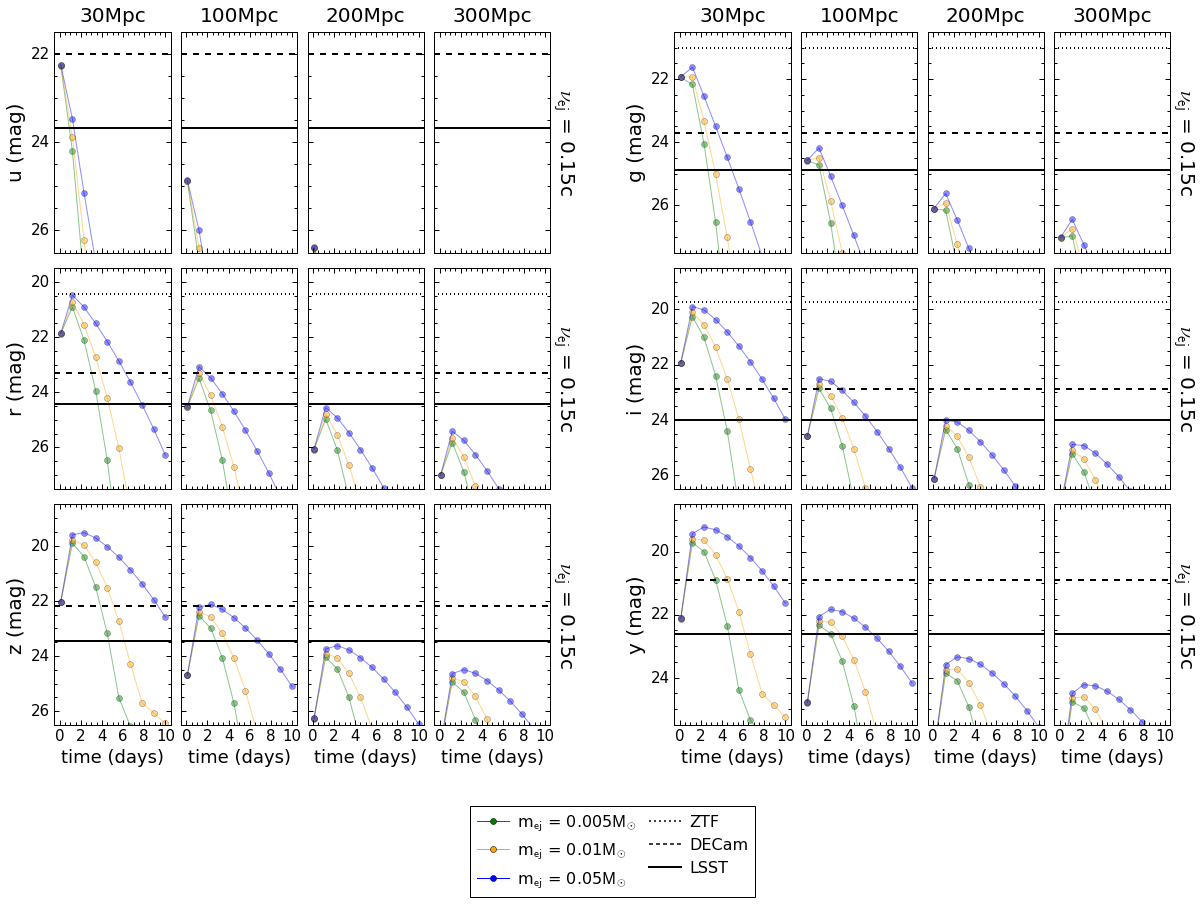

In [534]:
plt_results(test_sample, Kilonovae)

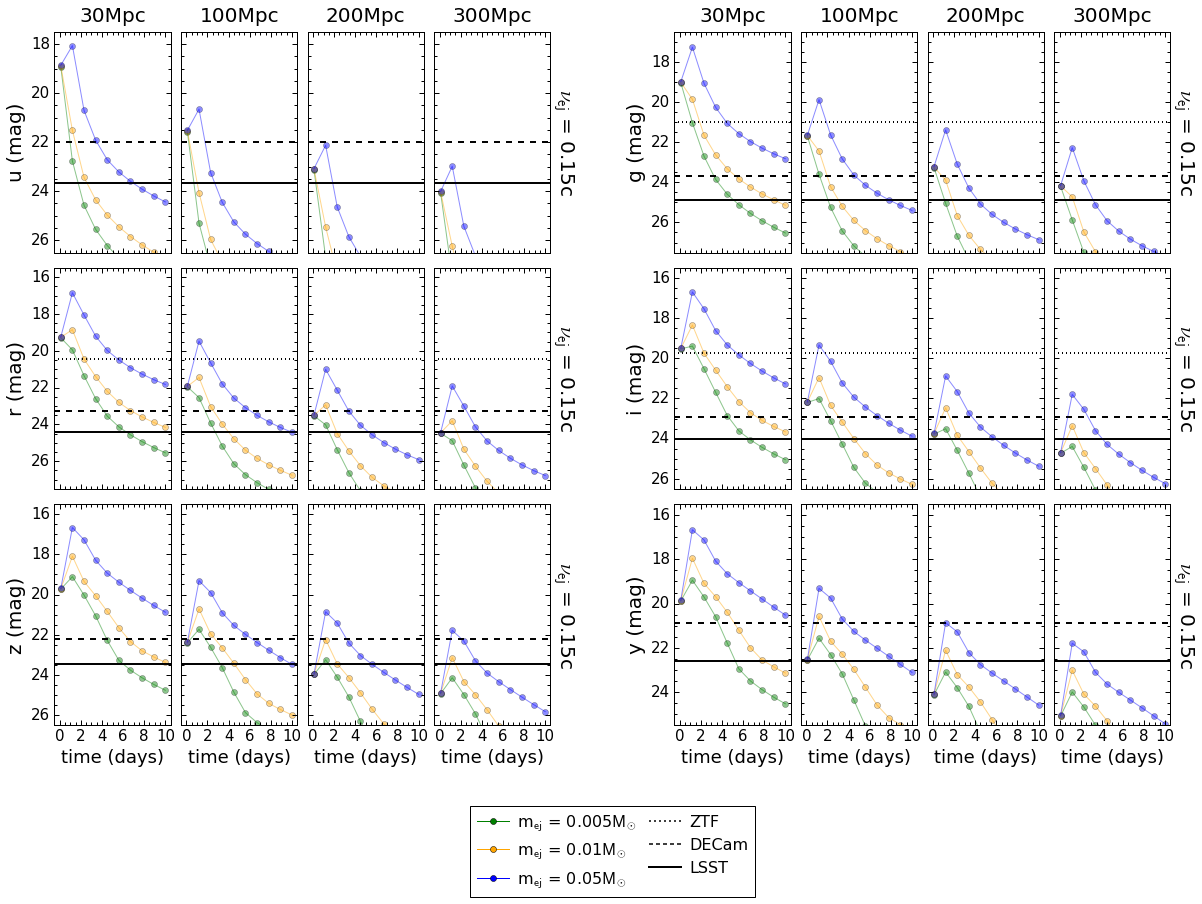

In [535]:
plt_results(twocomp_test, Kilonovaetwo)

In [2016]:
threecompdist = np.tile(ThreeComp, (3,1))

In [2017]:
villarmodels = np.insert(threecompdist, [len(threecompdist[0])], [[30],[100],[300]], axis=1)

In [2019]:
gwtime, gwkilo = time_tables(np.linspace(0.1,10,20), villarmodels)

In [2321]:
#plt_total(gwtime, gwkilo)

In [57]:
mags_dict

{'u': array([   inf,  22.  ,  23.68,  25.  ]),
 'g': array([ 21.  ,  23.7 ,  24.89,  26.  ]),
 'r': array([ 20.44,  23.3 ,  24.43,  25.4 ]),
 'i': array([ 19.72,  22.9 ,  24.  ,  25.  ]),
 'z': array([   inf,  22.2 ,  23.45,  24.4 ]),
 'y': array([  inf,  20.9,  22.6,  23.4])}

In [58]:
def generate_params(param_num, components, color=None):
    if isinstance(components, int):
        comp_nums = np.full(param_num, components)
    elif len(components) != param_num:
        raise ValueError('Components must have length param_num.')
    else:
        comp_nums = components
        
    param_list = [gen_params(comp_num, color) for comp_num in comp_nums]
    
    return param_list

def gen_params(comp_num, color=None):
    mass_ej = np.random.uniform(1.e-3, 5.e-2, comp_num)
    vel_ej = np.random.uniform(0.1, 0.3, comp_num)
    if comp_num == 1 and color == None:
        colors = ['blue']
    elif comp_num == 1 and color != None:
        colors = [color]
    elif comp_num == 2:
        colors = ['blue', 'red']
    else:
        colors = Colors
    temp = np.asarray([np.mean(np.random.normal(Temp[color][0], Temp[color][1:], (comp_num,2))[i])
                       for color, i in zip(colors, range(comp_num))])
    opac = np.asarray([Opacity[color] for color in colors]) 
    return [[mass_ej[i], vel_ej[i], temp[i], opac[i]] for i in range(comp_num)]

In [59]:
sim0 = generate_params(1, 1)
sim1 = generate_params(1, 1)
sim2 = generate_params(1, 1)

In [61]:
#sim = kilonova_simulation(Times, sim0, 100, model = False)
#simone = kilonova_simulation(Times, sim1, 100, model = True)
#simtwo = kilonova_simulation(Times, sim2, 100, model = True)

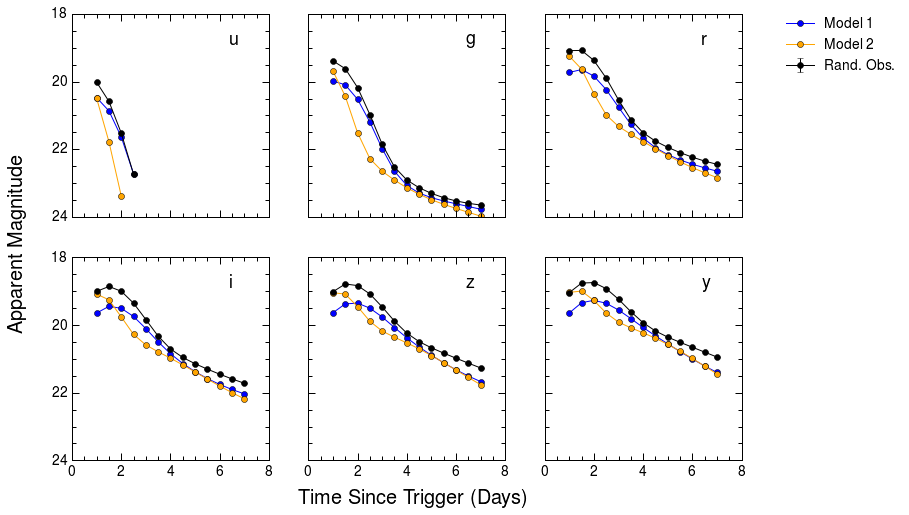

In [230]:
majorFormatter = FormatStrFormatter('%d')
majorLocatorx = MultipleLocator(2)
majorLocatory = MultipleLocator(2)
minorLocatorx = MultipleLocator(1)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
f.set_figheight(8)
f.set_figwidth(12)
f.text(0.52, 0.05, 'Time Since Trigger (Days)', ha='center', fontsize=axeslabelsize-5)
f.text(0.05, 0.5, 'Apparent Magnitude', va='center', rotation='vertical', fontsize=axeslabelsize-5)
plt.gca().invert_yaxis()
for band, ax in zip(bands, [ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.errorbar(sim[0]['day'], sim[0][band], yerr=sim[1][band], fmt='o-', color='black', label='Rand. Obs.')
    ax.plot(simone['day'], simone[band], 'o-', color='Blue', label='Model 1')
    ax.plot(simtwo['day'], simtwo[band], 'o-', color='Orange', label='Model 2')
    ax.text(0.8, 0.85, band, fontsize=18, transform=ax.transAxes)
    
    plt.xlim(0,8)
    ax.tick_params(labelsize=tickfontsize-6)
    plt.yticks(fontsize=tickfontsize) 
    ax.xaxis.set_major_locator(majorLocatorx)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='major',length=majorticklength, width=majortickwidth, colors='k')
    ax.tick_params(which='minor',length=minorticklength, width=minortickwidth, colors='k')
    ax.yaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_major_locator(majorLocatory)
    ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.legend(numpoints=1, fontsize=legend-3, frameon=False, bbox_to_anchor=(1.85,2.25))

plt.show()

In [231]:
randoms = calc_likelihood(Times, sim0, [sim1, sim2], 100)

In [232]:
print('Log-Likelihood Calculations')
for band in bands:
    print(f'{band}: Model 1 = {randoms[band][0]:0.3f}; Model 2 = {randoms[band][1]:0.3f}')

Log-Likelihood Calculations
u: Model 1 = -6013.781; Model 2 = -99420.966
g: Model 1 = -17418.884; Model 2 = -105937.069
r: Model 1 = -28158.987; Model 2 = -77809.659
i: Model 1 = -34732.806; Model 2 = -62723.229
z: Model 1 = -37977.056; Model 2 = -53358.763
y: Model 1 = -38246.353; Model 2 = -45535.352


In [233]:
m_one = 'Model 1'
m_two = 'Model 2'
print('Better Model')
for band in bands:
    print(f'{band}: {m_one if randoms[band][0] > randoms[band][1] else m_two}')

Better Model
u: Model 1
g: Model 1
r: Model 1
i: Model 1
z: Model 1
y: Model 1


In [2387]:
res

     fun: 0.8000000011920985
     jac: array([ 0.80000002, -1.59999999])
 message: 'Optimization terminated successfully.'
    nfev: 13
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 1.4,  1.7])